In [1]:
import torch
import torchvision
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, RandomSampler, random_split
from tensorflow.keras.callbacks import EarlyStopping
from torch.utils.data import TensorDataset
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten,Conv2D,MaxPooling2D,GRU, LSTM,Input, Concatenate, LeakyReLU
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import BatchNormalization, Dropout
import librosa
import IPython
import soundfile as sf
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
import glob
import os, random
import pickle
!pip install simplejson
import simplejson
import pandas as pd
import ast
from matplotlib.pyplot import figure
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense,Activation
from tensorflow.keras.models import load_model,save_model
import tensorflow_datasets as tf_ds
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.metrics import BinaryAccuracy
from keras.layers import Layer
from tensorflow.keras.activations import sigmoid
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
import copy
from itertools import combinations,product
import seaborn as sns
import gzip
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import mnist
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.nn import functional as F
from torch.autograd import Variable
from tqdm import tqdm
plt.style.use('ggplot')


You should consider upgrading via the 'c:\users\papu_\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:

# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
folder_path = "/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 5/"
folder_path = ''

## Problem 1: RNNs as a Generative Model

### Loading data and data loader for network

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)
print('X_test:  ' , X_test.shape)
print('Y_test:  ' , Y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


In [5]:
X_train, Y_train, X_test, Y_test = X_train/255, Y_train, X_test/255, Y_test

In [6]:
# Split into patches - TRAIN VERSION
# From 28x28 to 7x7 with 4 such patches

image_patched_2d = []
image_patched_1d = []
count = 0

for img in X_train:
  image_current_2d = []
  image_current_1d = []
  for i in range(0,img.shape[0], 7):
    for j in range(0,img.shape[1], 7):
      image_current_2d.append( np.array(img[i:i+7, j:j+7]) )
      image_current_1d.append( np.array(img[i:i+7, j:j+7]).flatten() )

  image_patched_2d.append( image_current_2d )
  image_patched_1d.append( image_current_1d )

image_patched_2d = np.array(image_patched_2d)
image_patched_1d = np.array(image_patched_1d)

print(image_patched_2d.shape, image_patched_1d.shape)


(60000, 16, 7, 7) (60000, 16, 49)


In [7]:
# Split into patches - TEST VERSION
# From 28x28 to 7x7 with 4 such patches

test_image_patched_2d = []
test_image_patched_1d = []
count = 0

for img in X_test:
  test_image_current_2d = []
  test_image_current_1d = []
  for i in range(0,img.shape[0], 7):
    for j in range(0,img.shape[1], 7):
      test_image_current_2d.append( np.array(img[i:i+7, j:j+7]) )
      test_image_current_1d.append( np.array(img[i:i+7, j:j+7]).flatten() )

  test_image_patched_2d.append( test_image_current_2d )
  test_image_patched_1d.append( test_image_current_1d )

test_image_patched_2d = np.array(test_image_patched_2d)
test_image_patched_1d = np.array(test_image_patched_1d)

print(test_image_patched_2d.shape, test_image_patched_1d.shape)


(10000, 16, 7, 7) (10000, 16, 49)


In [8]:
# Define train and test data
x_train = []
y_train = []

for idx in range(len(image_patched_1d)):
  x_train.append(image_patched_1d[idx, 0:16, :])
  y_train.append(image_patched_1d[idx, 1:, :])

x_train = np.array(x_train)
y_train = np.array(y_train)


In [9]:
# Define train and test data
x_test = []
y_test = []

for idx in range(len(test_image_patched_1d)):
  x_test.append(test_image_patched_1d[idx, 0:16, :])
  y_test.append(test_image_patched_1d[idx, 1:, :])

x_test = np.array(x_test)
y_test = np.array(y_test)


In [10]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 16, 49) (10000, 16, 49) (60000, 15, 49) (10000, 15, 49)


In [11]:
# # Normalize data

# for i in range(0,len(x_test)):
#   x_test[i] = x_test[i]/255

# for i in range(0,len(x_train)):
#   x_train[i] = x_train[i]/255

#### LSTM Model

In [12]:
model = Sequential()
model.add(Input(shape=(None,49))) # here first None specifies batch size
model.add(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.HeNormal(), activation='relu' ))
model.add(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.HeNormal(), activation='relu' ))
model.add(Dropout(rate = 0.15))
model.add(Dense(49, activation=lambda x : tf.nn.leaky_relu(x, alpha=0.01), kernel_initializer = tf.keras.initializers.HeNormal()))

In [13]:
# Or use this tf.keras.losses.KLDivergence()
model.compile( loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) )

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train[:, 0:15, :], y_train, epochs=100, callbacks=callback, batch_size=100, validation_data=[x_test[:, 0:15, :], y_test])


Epoch 1/100
600/600 [==============================] - 71s 111ms/step - loss: 0.0578 - val_loss: 0.0417
Epoch 2/100
600/600 [==============================] - 62s 103ms/step - loss: 0.0401 - val_loss: 0.0361
Epoch 3/100
600/600 [==============================] - 62s 103ms/step - loss: 0.0368 - val_loss: 0.0336
Epoch 4/100
600/600 [==============================] - 61s 101ms/step - loss: 0.0352 - val_loss: 0.0325
Epoch 5/100
600/600 [==============================] - 63s 105ms/step - loss: 0.0341 - val_loss: 0.0319
Epoch 6/100
600/600 [==============================] - 61s 102ms/step - loss: 0.0333 - val_loss: 0.0312
Epoch 7/100
600/600 [==============================] - 61s 101ms/step - loss: 0.0327 - val_loss: 0.0311
Epoch 8/100
600/600 [==============================] - 65s 108ms/step - loss: 0.0322 - val_loss: 0.0304
Epoch 9/100
600/600 [==============================] - 64s 107ms/step - loss: 0.0318 - val_loss: 0.0302
Epoch 10/100
600/600 [==============================] - 64s 106m

#### Checking just one random image

In [ ]:
y_pred_patch = model.predict(np.expand_dims(x_test[200, 0:8, :], axis=0)) # Choosing a random image - and input first 8 patches
print(y_pred_patch.shape)

In [ ]:
idx=7
for i in range(7):
  y_pred_next_patch = model.predict(y_pred_patch)
  # Join to sequence so the next input will have the predicted patch values also
  y_pred_patch = np.hstack((y_pred_patch, y_pred_next_patch[:,idx,:].reshape(1,1,49)))
  idx+=1

In [ ]:
y_pred_patch = y_pred_patch[:,7:,:]
# Merge original image first 8 original patches and the rest from predicted patches
pred_image = np.concatenate((x_test[200, :8, :], y_pred_patch[0])).reshape(1,16,49)
pred_image = pred_image[0].reshape(16, 7, 7)
print(pred_image.shape)


(16, 7, 7)


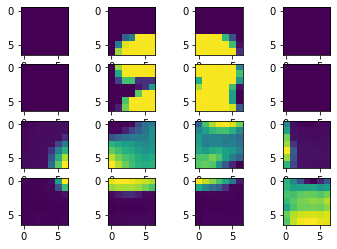

In [ ]:
fig = plt.figure()
for index, image in enumerate(pred_image):
    ax = plt.subplot(4, 4, index + 1)
    ax.imshow(image)
plt.show()

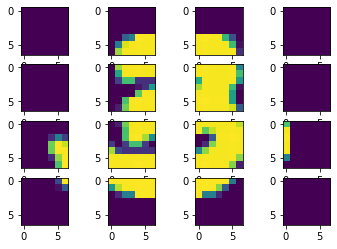

In [ ]:
actual_image = x_test[200].reshape(16, 7, 7)

fig = plt.figure()
for index, image in enumerate(actual_image):
    ax = plt.subplot(4, 4, index + 1)
    ax.imshow(image)
plt.show()

#### Construct 10x10 grid

In [ ]:
x_test_10=[]
for i in range(0,10):
  y_test_ix = np.where(Y_test == i)[0]
  print(i, len(y_test_ix))
  x_test_10.append(x_test[y_test_ix[0:10]])

  

0 980
1 1135
2 1032
3 1010
4 982
5 892
6 958
7 1028
8 974
9 1009


In [ ]:
def predict_from_patches(img):

  y_pred_patch = model.predict(np.expand_dims(img[0:8, :], axis=0)) # Choosing a random image - and input first 8 patches
  idx=7
  for i in range(7):
    y_pred_next_patch = model.predict(y_pred_patch)
    # Join to sequence so the next input will have the predicted patch values also
    y_pred_patch = np.hstack((y_pred_patch, y_pred_next_patch[:,idx,:].reshape(1,1,49)))
    idx+=1

  y_pred_patch = y_pred_patch[:,7:,:]
  # Merge original image first 8 original patches and the rest from predicted patches
  pred_image = np.expand_dims( np.concatenate((img[0:8, :], y_pred_patch[0])), axis=0 )
  pred_image = pred_image[0].reshape(16, 7, 7)

  # t = img.reshape(16, 7, 7)
  t = pred_image
  all = np.hstack([t[0], t[1], t[2], t[3]])
  for i in range(4, 16, 4):
    each_vert = np.hstack([t[i], t[i+1], t[i+2], t[i+3]])
    all = np.vstack([all, each_vert])
  return all



In [ ]:
predicted_10 = []
for i in range(len(x_test_10)):
  print(i)
  for j in range(10):  
    print(x_test_10[i].shape)
    predicted_10.append( predict_from_patches(x_test_10[i][j]) )


In [ ]:
print('After prediction 10 of all digits', len(predicted_10))

After prediction 10 of all digits 100


In [ ]:
actual_10 = []
for i in range(len(x_test_10)):
  for j in range(10):
    img = x_test_10[i][j]
    t = img.reshape(16, 7, 7)
    all = np.hstack([t[0], t[1], t[2], t[3]])
    for k in range(4, 16, 4):
      each_vert = np.hstack([t[k], t[k+1], t[k+2], t[k+3]])
      all = np.vstack([all, each_vert])
      
    actual_10.append( all )


In [ ]:
len(actual_10)

100

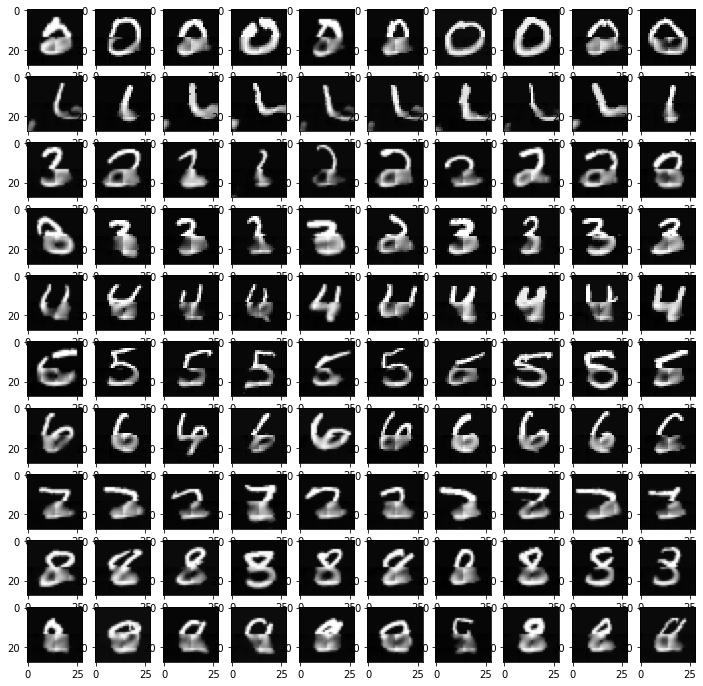

In [ ]:
fig, ax = plt.subplots(10,10,figsize=(12,12))
img_index = 0
for i in range(10):
  for j in range(10):
    ax[i][j].imshow(predicted_10[img_index], cmap='gray')
    img_index+=1

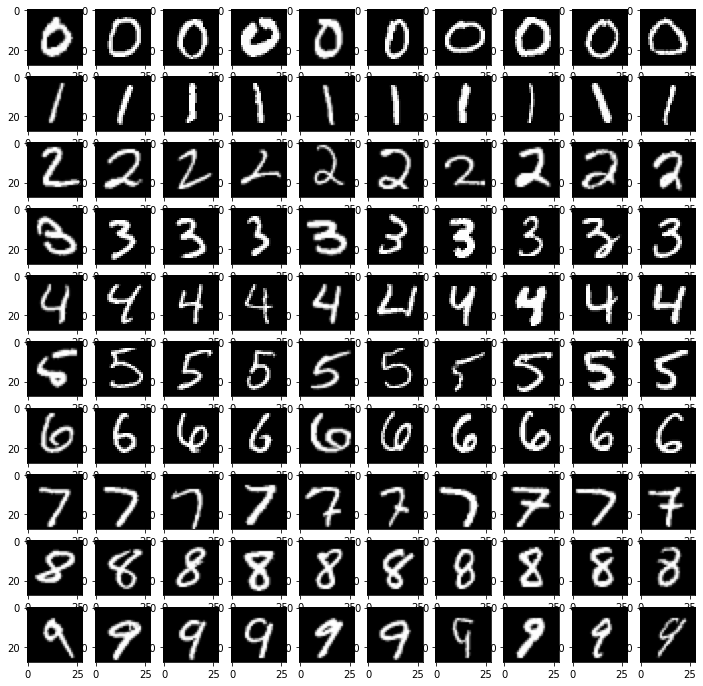

In [ ]:
fig, ax = plt.subplots(10,10,figsize=(12,12))
img_index = 0
for i in range(10):
  for j in range(10):
    ax[i][j].imshow(actual_10[img_index], cmap='gray')
    img_index+=1

## Problem 2: VAE on poor sevens

In [4]:
import pickle
# Load files from pkl file
with open( folder_path + 'hw5_tr7.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open( folder_path + 'hw5_te7.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [5]:
print(train_data.shape, test_data.shape)

(6265, 28, 28) (1028, 28, 28)


In [20]:
# Reference: https://mmeendez8.github.io/2019/01/24/vae-tensorflow.html
# Another: https://keras.io/examples/generative/vae/#create-a-sampling-layer

### Generate or reconstruct input image from the data sampled from latent space. Make the K-1 dimensions same and just vary across one dimension

In [1]:
# def encoder():
#     return nn.Sequential(nn.Conv2d(1, 16, kernel_size = 4, stride = 2),
#                       nn.ReLU(),
#                       nn.Conv2d(16, 32, kernel_size = 4, stride = 2),
#                       nn.ReLU(),
#                       nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
#                       nn.ReLU())

# def decoder():
#     return nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
#                       nn.ReLU(),
#                       nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
#                       nn.ReLU(),
#                       nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2),
#                       nn.Sigmoid())

# def encoder_loss(mean_value,logvar):
#         en_loss = -0.5 * torch.mean(1 + logvar - mean_value.pow(2) - logvar.exp())
#         return en_loss

# def decoder_loss(decoder_data, input_data):
#     decoder_data = decoder_data.reshape((decoder_data.shape[0],28,28))
#     bce = 0.001 * F.binary_cross_entropy(decoder_data, input_data, reduction = 'sum')
#     return bce
    
# def final_loss(bce_loss, mu, log_var): # this is not the problem
#     # Add the reconstruction loss and the KL-Divergence.
#     kl_loss =  -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
#     # print('kl',kl_loss)
#     final = kl_loss + bce_loss
#     return final


# class variational_autoencoders(nn.Module): 
#     def __init__(self):
#         super(variational_autoencoders, self).__init__()
#         # encoder
#         # self.encoder = encoder()
#         # self.decoder = decoder()
#         # Using sequential works correctly
#         self.e1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size = 4, stride = 2),
#                       nn.ReLU(),
#                       nn.Conv2d(16, 32, kernel_size = 4, stride = 2),
#                       nn.ReLU(),
#                       nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
#                       nn.ReLU())
        
#         self.d1 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
#                       nn.ReLU(),
#                       nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
#                       nn.ReLU(),
#                       nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2),
#                       nn.Sigmoid())

#         # Fully connected layers
#         self.latent_dim = 5 # 5
#         self.fc_mu = nn.Linear(64, self.latent_dim)
#         self.fc_log_var = nn.Linear(64, self.latent_dim)
#         self.fc2 = nn.Linear(self.latent_dim, 64)

        

#     def reparametrize(self, mu, log_var):
#         std = torch.exp(0.5*log_var)
#         eps = torch.randn_like(std) # `randn_like` as we need the same size (takes std as input and returns eps values of same size)
#         sample = mu + (eps * std) # sampling
#         return sample

    
# #     def encode(self, data):
# #         data = data[:,np.newaxis, :,:].cuda()
# #         x = self.e1(data)
# #         x = x.view(x.size(0), -1)
# #         mu = self.fc_mu(x)
# #         log_var = self.fc_log_var(x)
# #         latent_z= self.reparametrize(mu, log_var)
# #         latent_z= self.fc2(latent_z)
# #         latent_z= latent_z.view(latent_z.size(0), 64, 1, 1) # to do deconv function

# #         return latent_z, mu, log_var

# #     def decode(self,latent_z):
# #         # decoding
# #         reconstructed_data = self.d1(latent_z)
# #         return reconstructed_data

#     def forward(self, data):
#         # repar,mean_value,logvar = self.encode(data)
#         # repar = self.decode(repar)
        
#         data = data[:,np.newaxis, :,:].cuda()
#         x = self.e1(data)
#         x = x.view(x.size(0), -1)
#         mean_value = self.fc_mu(x)
#         log_var = self.fc_log_var(x)
#         latent_z= self.reparametrize(mu, log_var)
#         latent_z= self.fc2(latent_z)
#         latent_z= latent_z.view(latent_z.size(0), 64, 1, 1) # to do deconv function
#         repar = self.d1(latent_z)
        
#         return repar, mean_value, log_var

# def train(model, train_dataloader, train_dataset, optimizer, loss_criteria):
#     model.train()
#     running_loss = 0.0
#     counter = 0
#     # print(len(train_dataset), enumerate(train_dataloader), )
#     for i, data in tqdm( enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)):
#         if(torch.cuda.is_available()):
#             data =  data.float().to(device)
#         else:
#             data = data.float()
#         optimizer.zero_grad()
#         reconstructed_data, mu, logvar = model(data)
#         e_loss = encoder_loss(mu, logvar)
#         bce_loss = decoder_loss(reconstructed_data, data)  
#         loss = e_loss + bce_loss
#         # reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0],28,28))
#         # bce_loss = 0.001 * F.binary_cross_entropy(reconstructed_data, data, reduction = 'sum')
#         # loss = final_loss(bce_loss, mu, logvar)
        
#         loss.backward(retain_graph=True)
#         running_loss += loss.item()
#         optimizer.step()
#         counter += 1
        
#     train_loss = running_loss / counter 
#     return train_loss    

# # RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

# def validation(model, valid_dataloader, valid_dataset, optimizer, loss_criteria):
#     model.eval()
#     running_loss = 0.0
#     counter = 0
            
#     for i, data in tqdm(enumerate(valid_dataloader), total=int(len(valid_dataset)/valid_dataloader.batch_size)):
#         if(torch.cuda.is_available()):
#             data =  data.float().to(device)
#         else:
#             data = data.float()
#         reconstructed_data, mu, logvar = model(data)
#         e_loss = encoder_loss(mu, logvar)
#         bce_loss = decoder_loss(reconstructed_data, data)  
#         loss = e_loss + bce_loss
#         # reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0],28,28))
#         # bce_loss = 0.001 * F.binary_cross_entropy(reconstructed_data, data, reduction = 'sum')
#         # loss = final_loss(bce_loss, mu, logvar)
        
#         running_loss += loss.item()
#         counter += 1
        
#     valid_loss = running_loss / counter 
#     return valid_loss

# # initialize the model
# model = variational_autoencoders().to(device)
# model.apply(he_weights)

# # set the learning parameters
# lr = 0.0001
# epochs = 30
# batch_size = 128
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# all_train_loss = []
# all_valid_loss = []

# for epoch in range(epochs):
#     print(f"Epoch {epoch+1} of {epochs}")
#     train_epoch_loss = train(model, train_dataloader, train_data, optimizer, loss_criteria)
#     valid_epoch_loss = validation(model, valid_dataloader, test_data, optimizer, loss_criteria)
    
#     all_train_loss.append(train_epoch_loss)
#     all_valid_loss.append(valid_epoch_loss)
    
#     print(f"Training Loss: {train_epoch_loss:.5f}")
#     print(f"Validation Loss: {valid_epoch_loss:.5f}")
#     # if early_stopper.early_stop(valid_epoch_loss):             
#     #     break
        


In [230]:
def encoder():
    return nn.Sequential(nn.Conv2d(1, 16, kernel_size = 4, stride = 2),
                      nn.ReLU(),
                      nn.Conv2d(16, 32, kernel_size = 4, stride = 2),
                      nn.ReLU(),
                      nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
                      nn.ReLU())

def decoder():
    return nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
                      nn.ReLU(),
                      nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
                      nn.ReLU(),
                      nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2),
                      nn.Sigmoid())

def encoder_loss(mean_value,logvar):
        en_loss = -0.5 * torch.mean(1 + logvar - mean_value.pow(2) - logvar.exp())
        return en_loss

def decoder_loss(decoder_data, input_data):
    decoder_data = decoder_data.reshape((decoder_data.shape[0],28,28))
    bce = 0.001 * F.binary_cross_entropy(decoder_data, input_data, reduction = 'sum')
    return bce
    
def final_loss(bce_loss, mu, log_var): # this is not the problem
    # Add the reconstruction loss and the KL-Divergence.
    kl_loss =  -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    # print('kl',kl_loss)
    final = kl_loss + bce_loss
    return final


class variational_autoencoders(nn.Module): 
    def __init__(self):
        super(variational_autoencoders, self).__init__()
        # encoder
        # self.encoder = encoder()
        # self.decoder = decoder()
        # Using sequential works correctly
        self.e1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size = 4, stride = 2),
                      nn.ReLU(),
                      nn.Conv2d(16, 32, kernel_size = 4, stride = 2),
                      nn.ReLU(),
                      nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
                      nn.ReLU())
        
        self.d1 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
                      nn.ReLU(),
                      nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
                      nn.ReLU(),
                      nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2),
                      nn.Sigmoid())

        # Fully connected layers
        self.latent_dim = 5 # 5
        self.fc_mu = nn.Linear(64, self.latent_dim)
        self.fc_log_var = nn.Linear(64, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, 64)

        

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # `randn_like` as we need the same size (takes std as input and returns eps values of same size)
        sample = mu + (eps * std) # sampling
        return sample

    
    def encode(self, data):
        data = data[:,np.newaxis, :,:].cuda()
        x = self.e1(data)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        latent_z= self.reparametrize(mu, log_var)
        latent_z= self.fc2(latent_z)
        latent_z= latent_z.view(latent_z.size(0), 64, 1, 1) # to do deconv function

        return latent_z, mu, log_var

    def decode(self,latent_z):
        # decoding
        reconstructed_data = self.d1(latent_z)
        return reconstructed_data

    def forward(self, x):
        repar,mean_value,log_var = self.encode(x)
        repar = self.decode(repar)
        
        # x = x[:,np.newaxis, :,:].cuda()
        # x = self.e1(x)
        # x = x.view(x.size(0), -1)
        # mean_value = self.fc_mu(x)
        # log_var = self.fc_log_var(x)
        # latent_z= self.reparametrize(mu, log_var)
        # latent_z= self.fc2(latent_z)
        # latent_z= latent_z.view(latent_z.size(0), 64, 1, 1) # to do deconv function
        # repar = self.d1(latent_z)
        
        return repar, mean_value, log_var

def train(model, train_dataloader, train_dataset, optimizer, loss_criteria):
    model.train()
    running_loss = 0.0
    counter = 0
    # print(len(train_dataset), enumerate(train_dataloader), )
    for i, data in tqdm( enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)):
        if(torch.cuda.is_available()):
            data =  data.float().to(device)
        else:
            data = data.float()
        optimizer.zero_grad()
        reconstructed_data, mu, logvar = model(data)
        reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0],28,28))
        bce_loss = 0.001 * F.binary_cross_entropy(reconstructed_data, data, reduction = 'sum')
        loss = final_loss(bce_loss, mu, logvar)
        
        loss.backward(retain_graph=True)
        running_loss += loss.item()
        optimizer.step()
        counter += 1
        
    train_loss = running_loss / counter 
    return train_loss    

# RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

def validation(model, valid_dataloader, valid_dataset, optimizer, loss_criteria):
    model.eval()
    running_loss = 0.0
    counter = 0
            
    for i, data in tqdm(enumerate(valid_dataloader), total=int(len(valid_dataset)/valid_dataloader.batch_size)):
        if(torch.cuda.is_available()):
            data =  data.float().to(device)
        else:
            data = data.float()
        reconstructed_data, mu, logvar = model(data)
        reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0],28,28))
        bce_loss = 0.001 * F.binary_cross_entropy(reconstructed_data, data, reduction = 'sum')
        loss = final_loss(bce_loss, mu, logvar)
        
        running_loss += loss.item()
        counter += 1
        
    valid_loss = running_loss / counter 
    return valid_loss

# initialize the model
model = variational_autoencoders().to(device)
model.apply(he_weights)

# set the learning parameters
lr = 0.0001
epochs = 5
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
all_train_loss = []
all_valid_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_dataloader, train_data, optimizer, loss_criteria)
    valid_epoch_loss = validation(model, valid_dataloader, test_data, optimizer, loss_criteria)
    
    all_train_loss.append(train_epoch_loss)
    all_valid_loss.append(valid_epoch_loss)
    
    print(f"Training Loss: {train_epoch_loss:.5f}")
    print(f"Validation Loss: {valid_epoch_loss:.5f}")
    # if early_stopper.early_stop(valid_epoch_loss):             
    #     break
        


Epoch 1 of 5


49it [00:00, 72.21it/s]                                                                                                                          
9it [00:00, 264.73it/s]                                                                                                                          


Training Loss: 68.45982
Validation Loss: 57.90954
Epoch 2 of 5


49it [00:00, 111.40it/s]                                                                                                                         
9it [00:00, 299.90it/s]                                                                                                                          


Training Loss: 55.21809
Validation Loss: 42.05159
Epoch 3 of 5


49it [00:00, 114.16it/s]                                                                                                                         
9it [00:00, 281.17it/s]                                                                                                                          


Training Loss: 41.70587
Validation Loss: 33.56436
Epoch 4 of 5


49it [00:00, 115.02it/s]                                                                                                                         
9it [00:00, 299.84it/s]                                                                                                                          


Training Loss: 34.57720
Validation Loss: 28.96836
Epoch 5 of 5


49it [00:00, 121.59it/s]                                                                                                                         
9it [00:00, 299.97it/s]                                                                                                                          

Training Loss: 30.94195
Validation Loss: 26.71005


In [281]:
# Load data 
# Load files from pkl file
with open( folder_path + 'hw5_tr7.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open( folder_path + 'hw5_te7.pkl', 'rb') as f:
    test_data = pickle.load(f)

print(train_data.shape, test_data.shape, len(train_data))

batch_size_train = 128 # batch size train set
batch_size_test = 128 # batch size test set

train_dataloader = torch.utils.data.DataLoader(dataset=train_data, 
                                             batch_size=batch_size_train, 
                                             shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(dataset=test_data, 
                                             batch_size=batch_size_test, 
                                             shuffle=False)


(6265, 28, 28) (1028, 28, 28) 6265


In [282]:
# Get device
if(torch.cuda.is_available()):
    device = torch.device('cuda')
    print(f"Using {device} device")
    print(torch.cuda.get_device_name(0))

# Kaiming He initialization
def he_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)
        
     # Now add for conv layer also
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)
        

Using cuda device
NVIDIA GeForce GTX 1650 Ti


### Define encoder and decoder and the two loss functions: First is the reconstruction loss function (pixel to pixel value comparison) and the KL Divergence loss which calculates the difference in distribution between the approximate posterior and the prior information (gaussian sampled - using reparameterization trick)

In [283]:
## Reference: https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

### WHY USING BINARY CROSS ENTROPY OVER MSE: # One thing I would like to add is why one would prefer binary crossentropy over MSE. Normally, the activation function of the last layer is sigmoid, which can lead to loss saturation ("plateau"). This saturation could prevent gradient-based learning algorithms from making progress. In order to avoid it, it is then good to have a log in the objective function to undo the exp in sigmoid, and this is why binary crossentropy is preferred (because it uses log, unlike MSE). I have read this in the Deep Learning Book, but I now can't find where exactly (I think chapter 8).

### Two losses: 1. reconstruction loss (between generated and actual image) and KL divergence loss to calculate the distance between the parametrized probability distribution and the assumed true probability distribution. In practice, the true distribution is usually assumed to be Gaussian and distance is measured in terms of Kullback-Leibler divergence
 


In [304]:
def final_loss(bce_loss, mu, log_var):
    # Add the reconstruction loss and the KL-Divergence.
    kl_loss =  -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()) # We could remove the mean and use sum but we have to use dependency on batch size by dividing the loss by batch size.
    # print('kl',kl_loss)
    final = kl_loss + bce_loss
    return final

In [305]:
class Convolution_VAE(nn.Module):
    def __init__(self, latent_dim = 5):
        super(Convolution_VAE, self).__init__()
        
        # encoder
        # Using sequential works correctly
        self.enc = nn.Sequential(nn.Conv2d(1, 16, kernel_size = 4, stride = 2),
                      nn.ReLU(),
                      nn.Conv2d(16, 32, kernel_size = 4, stride = 2),
                      nn.ReLU(),
                      nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
                      nn.ReLU())
        
        # Fully connected layers
        self.latent_dim = latent_dim # 5
        # self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(64, self.latent_dim)
        self.fc_log_var = nn.Linear(64, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, 64)
        
        self.dec = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
                      nn.ReLU(),
                      nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
                      nn.ReLU(),
                      nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2),
                      nn.Sigmoid())
    
    def encode(self, x):
        x = x[:,np.newaxis, :,:] # add channels as an axis 
        # encoding
        x = self.enc(x)
        
        # Flatten to 2d array for fc layers
        x = x.view(x.size(0), x.size(1))
        # x = self.fc1(x)
        mu = self.fc_mu(x) # get `mu` and `log_var`
        log_var = self.fc_log_var(x)
        
        # get the latent vector through reparameterization trick
        latent_z= self.reparameterization_trick(mu, log_var)
        return latent_z, mu, log_var
    
    def decode(self, latent_z):
        # decoding # 5 column input
        latent_z= self.fc2(latent_z) # Back to 64 dim and then decoder
        latent_z= latent_z.view(latent_z.size(0), 64, 1, 1) # to do deconv function
        reconstructed_data = self.dec(latent_z)
        return reconstructed_data
    
    def reparameterization_trick(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # `randn_like` as we need the same size (takes std as input and returns eps values of same size)
        sample = mu + (eps * std) # sampling
        
        return sample
    
    def forward(self, x):
        latent_z, mu, log_var = self.encode(x)
        reconstructed_data = self.decode(latent_z)
        
        # reconstructed_data = torch.sigmoid(x)
        # reconstructed_data = x # Since we use bce with logits loss (it does sigmoid itself) and is more numercially stable.
        return reconstructed_data, mu, log_var
    
    

In [306]:
# bce_loss = 0.001 * F.binary_cross_entropy(reconstructed_data, data, reduction = 'sum')
# e_loss = encoder_loss(mu, logvar)
# bce_loss = decoder_loss(data, reconstructed_data)        

def train(model, train_dataloader, train_dataset, optimizer, loss_criteria):
    model.train()
    running_loss = 0.0
    counter = 0
    # print(len(train_dataset), enumerate(train_dataloader), )
    for i, data in tqdm( enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)):
        if(torch.cuda.is_available()):
            data =  data.float().to(device)
        else:
            data = data.float()
        optimizer.zero_grad()    
        reconstructed_data, mu, logvar = model(data) 
        reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0],28,28))
        bce_loss = 0.001 * F.binary_cross_entropy(reconstructed_data, data, reduction = 'sum')
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        counter += 1
        
    train_loss = running_loss / counter 
    return train_loss

def validation(model, valid_dataloader, valid_dataset, optimizer, loss_criteria):
    model.eval()
    running_loss = 0.0
    counter = 0
            
    for i, data in tqdm(enumerate(valid_dataloader), total=int(len(valid_dataset)/valid_dataloader.batch_size)):
        if(torch.cuda.is_available()):
            data =  data.float().to(device)
        else:
            data = data.float()
        reconstructed_data, mu, logvar = model(data)
        
        reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0],28,28))
        bce_loss = 0.001 * F.binary_cross_entropy(reconstructed_data, data, reduction = 'sum')
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        counter += 1
        
    valid_loss = running_loss / counter 
    return valid_loss


In [307]:
# initialize the model
model = Convolution_VAE().to(device)
model.apply(he_weights)

# set the learning parameters
lr = 0.0001
epochs = 80
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_criteria = nn.BCELoss()
all_train_loss = []
all_valid_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_dataloader, train_data, optimizer, loss_criteria)
    valid_epoch_loss = validation(model, valid_dataloader, test_data, optimizer, loss_criteria)
    
    all_train_loss.append(train_epoch_loss)
    all_valid_loss.append(valid_epoch_loss)
    
    print(f"Training Loss: {train_epoch_loss:.5f}")
    print(f"Validation Loss: {valid_epoch_loss:.5f}")
    # if early_stopper.early_stop(valid_epoch_loss):             
    #     break
        

Epoch 1 of 80


49it [00:00, 78.28it/s]                                                                                                                          
9it [00:00, 333.01it/s]                                                                                                                          


Training Loss: 64.71351
Validation Loss: 56.34711
Epoch 2 of 80


49it [00:00, 119.22it/s]                                                                                                                         
9it [00:00, 310.35it/s]                                                                                                                          


Training Loss: 57.42912
Validation Loss: 44.82625
Epoch 3 of 80


49it [00:00, 121.29it/s]                                                                                                                         
9it [00:00, 310.31it/s]                                                                                                                          


Training Loss: 43.98381
Validation Loss: 35.23734
Epoch 4 of 80


49it [00:00, 117.78it/s]                                                                                                                         
9it [00:00, 321.44it/s]                                                                                                                          


Training Loss: 35.87867
Validation Loss: 29.77393
Epoch 5 of 80


49it [00:00, 118.93it/s]                                                                                                                         
9it [00:00, 236.80it/s]                                                                                                                          


Training Loss: 31.45244
Validation Loss: 26.82665
Epoch 6 of 80


49it [00:00, 110.86it/s]                                                                                                                         
9it [00:00, 290.22it/s]                                                                                                                          


Training Loss: 28.73692
Validation Loss: 24.75134
Epoch 7 of 80


49it [00:00, 121.29it/s]                                                                                                                         
9it [00:00, 310.35it/s]                                                                                                                          


Training Loss: 26.75340
Validation Loss: 23.01827
Epoch 8 of 80


49it [00:00, 119.07it/s]                                                                                                                         
9it [00:00, 310.43it/s]                                                                                                                          


Training Loss: 25.03044
Validation Loss: 21.58901
Epoch 9 of 80


49it [00:00, 117.81it/s]                                                                                                                         
9it [00:00, 300.06it/s]                                                                                                                          


Training Loss: 23.71869
Validation Loss: 20.65163
Epoch 10 of 80


49it [00:00, 119.52it/s]                                                                                                                         
9it [00:00, 300.17it/s]                                                                                                                          


Training Loss: 22.78194
Validation Loss: 19.86440
Epoch 11 of 80


49it [00:00, 117.22it/s]                                                                                                                         
9it [00:00, 272.75it/s]                                                                                                                          


Training Loss: 21.98734
Validation Loss: 19.25017
Epoch 12 of 80


49it [00:00, 119.31it/s]                                                                                                                         
9it [00:00, 300.02it/s]                                                                                                                          


Training Loss: 21.31274
Validation Loss: 18.65394
Epoch 13 of 80


49it [00:00, 119.14it/s]                                                                                                                         
9it [00:00, 281.25it/s]                                                                                                                          


Training Loss: 20.71418
Validation Loss: 18.16198
Epoch 14 of 80


49it [00:00, 123.12it/s]                                                                                                                         
9it [00:00, 310.34it/s]                                                                                                                          


Training Loss: 20.23967
Validation Loss: 17.81868
Epoch 15 of 80


49it [00:00, 124.68it/s]                                                                                                                         
9it [00:00, 290.26it/s]                                                                                                                          


Training Loss: 19.88140
Validation Loss: 17.54171
Epoch 16 of 80


49it [00:00, 121.17it/s]                                                                                                                         
9it [00:00, 321.40it/s]                                                                                                                          


Training Loss: 19.59821
Validation Loss: 17.29713
Epoch 17 of 80


49it [00:00, 120.69it/s]                                                                                                                         
9it [00:00, 310.38it/s]                                                                                                                          


Training Loss: 19.32902
Validation Loss: 17.08425
Epoch 18 of 80


49it [00:00, 117.69it/s]                                                                                                                         
9it [00:00, 281.29it/s]                                                                                                                          


Training Loss: 19.13360
Validation Loss: 16.90410
Epoch 19 of 80


49it [00:00, 118.93it/s]                                                                                                                         
9it [00:00, 310.36it/s]                                                                                                                          


Training Loss: 18.93331
Validation Loss: 16.78666
Epoch 20 of 80


49it [00:00, 119.02it/s]                                                                                                                         
9it [00:00, 310.44it/s]                                                                                                                          


Training Loss: 18.77593
Validation Loss: 16.64622
Epoch 21 of 80


49it [00:00, 121.59it/s]                                                                                                                         
9it [00:00, 321.42it/s]                                                                                                                          


Training Loss: 18.61457
Validation Loss: 16.48649
Epoch 22 of 80


49it [00:00, 122.50it/s]                                                                                                                         
9it [00:00, 290.38it/s]                                                                                                                          


Training Loss: 18.46927
Validation Loss: 16.42274
Epoch 23 of 80


49it [00:00, 116.67it/s]                                                                                                                         
9it [00:00, 299.88it/s]                                                                                                                          


Training Loss: 18.33939
Validation Loss: 16.30631
Epoch 24 of 80


49it [00:00, 116.88it/s]                                                                                                                         
9it [00:00, 264.76it/s]                                                                                                                          


Training Loss: 18.23168
Validation Loss: 16.19065
Epoch 25 of 80


49it [00:00, 121.85it/s]                                                                                                                         
9it [00:00, 300.04it/s]                                                                                                                          


Training Loss: 18.12702
Validation Loss: 16.07636
Epoch 26 of 80


49it [00:00, 120.99it/s]                                                                                                                         
9it [00:00, 321.65it/s]                                                                                                                          


Training Loss: 17.99596
Validation Loss: 16.01650
Epoch 27 of 80


49it [00:00, 121.89it/s]                                                                                                                         
9it [00:00, 300.02it/s]                                                                                                                          


Training Loss: 17.91173
Validation Loss: 15.94258
Epoch 28 of 80


49it [00:00, 118.93it/s]                                                                                                                         
9it [00:00, 310.23it/s]                                                                                                                          


Training Loss: 17.81254
Validation Loss: 15.88199
Epoch 29 of 80


49it [00:00, 117.23it/s]                                                                                                                         
9it [00:00, 281.24it/s]                                                                                                                          


Training Loss: 17.73540
Validation Loss: 15.82643
Epoch 30 of 80


49it [00:00, 107.46it/s]                                                                                                                         
9it [00:00, 310.37it/s]                                                                                                                          


Training Loss: 17.65934
Validation Loss: 15.73285
Epoch 31 of 80


49it [00:00, 123.11it/s]                                                                                                                         
9it [00:00, 310.44it/s]                                                                                                                          


Training Loss: 17.58176
Validation Loss: 15.71051
Epoch 32 of 80


49it [00:00, 111.11it/s]                                                                                                                         
9it [00:00, 257.15it/s]                                                                                                                          


Training Loss: 17.50626
Validation Loss: 15.65295
Epoch 33 of 80


49it [00:00, 117.78it/s]                                                                                                                         
9it [00:00, 321.27it/s]                                                                                                                          


Training Loss: 17.43950
Validation Loss: 15.55476
Epoch 34 of 80


49it [00:00, 124.05it/s]                                                                                                                         
9it [00:00, 310.46it/s]                                                                                                                          


Training Loss: 17.39174
Validation Loss: 15.50456
Epoch 35 of 80


49it [00:00, 119.10it/s]                                                                                                                         
9it [00:00, 257.18it/s]                                                                                                                          


Training Loss: 17.33623
Validation Loss: 15.50283
Epoch 36 of 80


49it [00:00, 117.51it/s]                                                                                                                         
9it [00:00, 290.33it/s]                                                                                                                          


Training Loss: 17.24038
Validation Loss: 15.39966
Epoch 37 of 80


49it [00:00, 121.89it/s]                                                                                                                         
9it [00:00, 299.97it/s]                                                                                                                          


Training Loss: 17.21362
Validation Loss: 15.40336
Epoch 38 of 80


49it [00:00, 121.89it/s]                                                                                                                         
9it [00:00, 300.00it/s]                                                                                                                          


Training Loss: 17.15844
Validation Loss: 15.33877
Epoch 39 of 80


49it [00:00, 117.23it/s]                                                                                                                         
9it [00:00, 290.29it/s]                                                                                                                          


Training Loss: 17.11019
Validation Loss: 15.33796
Epoch 40 of 80


49it [00:00, 115.84it/s]                                                                                                                         
9it [00:00, 272.71it/s]                                                                                                                          


Training Loss: 17.05825
Validation Loss: 15.26109
Epoch 41 of 80


49it [00:00, 117.49it/s]                                                                                                                         
9it [00:00, 299.86it/s]                                                                                                                          


Training Loss: 17.01705
Validation Loss: 15.24401
Epoch 42 of 80


49it [00:00, 117.79it/s]                                                                                                                         
9it [00:00, 290.35it/s]                                                                                                                          


Training Loss: 16.96572
Validation Loss: 15.22622
Epoch 43 of 80


49it [00:00, 116.12it/s]                                                                                                                         
9it [00:00, 310.33it/s]                                                                                                                          


Training Loss: 16.92514
Validation Loss: 15.18927
Epoch 44 of 80


49it [00:00, 118.27it/s]                                                                                                                         
9it [00:00, 300.13it/s]                                                                                                                          


Training Loss: 16.88210
Validation Loss: 15.17510
Epoch 45 of 80


49it [00:00, 117.73it/s]                                                                                                                         
9it [00:00, 290.32it/s]                                                                                                                          


Training Loss: 16.85394
Validation Loss: 15.12833
Epoch 46 of 80


49it [00:00, 119.85it/s]                                                                                                                         
9it [00:00, 299.91it/s]                                                                                                                          


Training Loss: 16.80192
Validation Loss: 15.08539
Epoch 47 of 80


49it [00:00, 120.69it/s]                                                                                                                         
9it [00:00, 321.40it/s]                                                                                                                          


Training Loss: 16.75319
Validation Loss: 15.05655
Epoch 48 of 80


49it [00:00, 116.94it/s]                                                                                                                         
9it [00:00, 300.06it/s]                                                                                                                          


Training Loss: 16.73537
Validation Loss: 15.02120
Epoch 49 of 80


49it [00:00, 117.23it/s]                                                                                                                         
9it [00:00, 310.29it/s]                                                                                                                          


Training Loss: 16.69047
Validation Loss: 15.04144
Epoch 50 of 80


49it [00:00, 120.69it/s]                                                                                                                         
9it [00:00, 321.37it/s]                                                                                                                          


Training Loss: 16.65991
Validation Loss: 14.96732
Epoch 51 of 80


49it [00:00, 120.55it/s]                                                                                                                         
9it [00:00, 299.93it/s]                                                                                                                          


Training Loss: 16.62706
Validation Loss: 14.94695
Epoch 52 of 80


49it [00:00, 122.50it/s]                                                                                                                         
9it [00:00, 299.85it/s]                                                                                                                          


Training Loss: 16.57327
Validation Loss: 14.92585
Epoch 53 of 80


49it [00:00, 110.11it/s]                                                                                                                         
9it [00:00, 290.20it/s]                                                                                                                          


Training Loss: 16.56003
Validation Loss: 14.90616
Epoch 54 of 80


49it [00:00, 114.22it/s]                                                                                                                         
9it [00:00, 243.25it/s]                                                                                                                          


Training Loss: 16.51456
Validation Loss: 14.85742
Epoch 55 of 80


49it [00:00, 117.05it/s]                                                                                                                         
9it [00:00, 299.93it/s]                                                                                                                          


Training Loss: 16.49406
Validation Loss: 14.83637
Epoch 56 of 80


49it [00:00, 115.65it/s]                                                                                                                         
9it [00:00, 299.92it/s]                                                                                                                          


Training Loss: 16.45812
Validation Loss: 14.80933
Epoch 57 of 80


49it [00:00, 113.69it/s]                                                                                                                         
9it [00:00, 299.90it/s]                                                                                                                          


Training Loss: 16.42680
Validation Loss: 14.84124
Epoch 58 of 80


49it [00:00, 119.51it/s]                                                                                                                         
9it [00:00, 281.23it/s]                                                                                                                          


Training Loss: 16.40921
Validation Loss: 14.80893
Epoch 59 of 80


49it [00:00, 116.96it/s]                                                                                                                         
9it [00:00, 310.45it/s]                                                                                                                          


Training Loss: 16.36858
Validation Loss: 14.76736
Epoch 60 of 80


49it [00:00, 117.76it/s]                                                                                                                         
9it [00:00, 310.31it/s]                                                                                                                          


Training Loss: 16.32930
Validation Loss: 14.73463
Epoch 61 of 80


49it [00:00, 119.22it/s]                                                                                                                         
9it [00:00, 300.04it/s]                                                                                                                          


Training Loss: 16.31869
Validation Loss: 14.75134
Epoch 62 of 80


49it [00:00, 119.80it/s]                                                                                                                         
9it [00:00, 300.05it/s]                                                                                                                          


Training Loss: 16.27533
Validation Loss: 14.71829
Epoch 63 of 80


49it [00:00, 124.05it/s]                                                                                                                         
9it [00:00, 321.46it/s]                                                                                                                          


Training Loss: 16.25426
Validation Loss: 14.69924
Epoch 64 of 80


49it [00:00, 119.80it/s]                                                                                                                         
9it [00:00, 310.34it/s]                                                                                                                          


Training Loss: 16.24641
Validation Loss: 14.65253
Epoch 65 of 80


49it [00:00, 120.41it/s]                                                                                                                         
9it [00:00, 272.67it/s]                                                                                                                          


Training Loss: 16.19985
Validation Loss: 14.64369
Epoch 66 of 80


49it [00:00, 121.89it/s]                                                                                                                         
9it [00:00, 310.28it/s]                                                                                                                          


Training Loss: 16.18704
Validation Loss: 14.62030
Epoch 67 of 80


49it [00:00, 121.59it/s]                                                                                                                         
9it [00:00, 299.97it/s]                                                                                                                          


Training Loss: 16.15558
Validation Loss: 14.60805
Epoch 68 of 80


49it [00:00, 124.05it/s]                                                                                                                         
9it [00:00, 290.54it/s]                                                                                                                          


Training Loss: 16.14228
Validation Loss: 14.59231
Epoch 69 of 80


49it [00:00, 122.50it/s]                                                                                                                         
9it [00:00, 310.34it/s]                                                                                                                          


Training Loss: 16.11727
Validation Loss: 14.55553
Epoch 70 of 80


49it [00:00, 120.39it/s]                                                                                                                         
9it [00:00, 290.30it/s]                                                                                                                          


Training Loss: 16.08966
Validation Loss: 14.57481
Epoch 71 of 80


49it [00:00, 122.16it/s]                                                                                                                         
9it [00:00, 321.62it/s]                                                                                                                          


Training Loss: 16.06139
Validation Loss: 14.48508
Epoch 72 of 80


49it [00:00, 119.81it/s]                                                                                                                         
9it [00:00, 321.24it/s]                                                                                                                          


Training Loss: 16.04549
Validation Loss: 14.50403
Epoch 73 of 80


49it [00:00, 122.49it/s]                                                                                                                         
9it [00:00, 310.00it/s]                                                                                                                          


Training Loss: 16.01996
Validation Loss: 14.48243
Epoch 74 of 80


49it [00:00, 120.10it/s]                                                                                                                         
9it [00:00, 310.45it/s]                                                                                                                          


Training Loss: 16.01538
Validation Loss: 14.49971
Epoch 75 of 80


49it [00:00, 111.87it/s]                                                                                                                         
9it [00:00, 281.13it/s]                                                                                                                          


Training Loss: 15.98004
Validation Loss: 14.51111
Epoch 76 of 80


49it [00:00, 118.18it/s]                                                                                                                         
9it [00:00, 243.31it/s]                                                                                                                          


Training Loss: 15.96494
Validation Loss: 14.50440
Epoch 77 of 80


49it [00:00, 102.73it/s]                                                                                                                         
9it [00:00, 290.22it/s]                                                                                                                          


Training Loss: 15.95445
Validation Loss: 14.43015
Epoch 78 of 80


49it [00:00, 120.10it/s]                                                                                                                         
9it [00:00, 310.30it/s]                                                                                                                          


Training Loss: 15.94425
Validation Loss: 14.41767
Epoch 79 of 80


49it [00:00, 117.22it/s]                                                                                                                         
9it [00:00, 300.01it/s]                                                                                                                          


Training Loss: 15.92352
Validation Loss: 14.43426
Epoch 80 of 80


49it [00:00, 121.59it/s]                                                                                                                         
9it [00:00, 310.38it/s]                                                                                                                          

Training Loss: 15.89630
Validation Loss: 14.42502


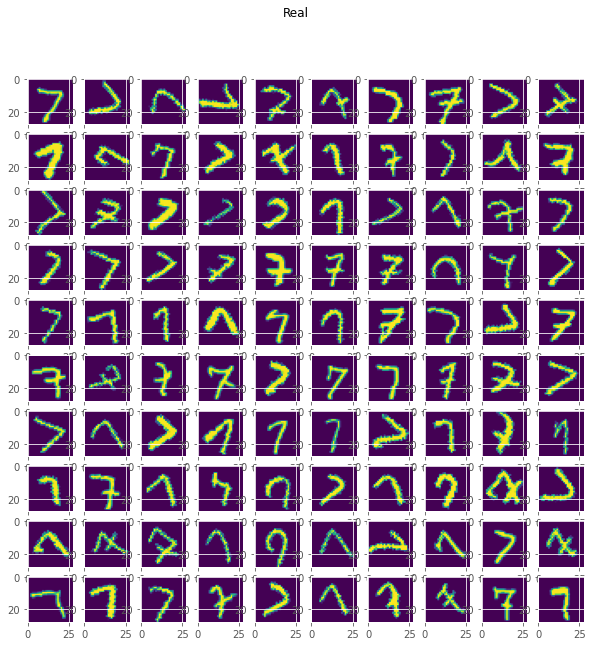

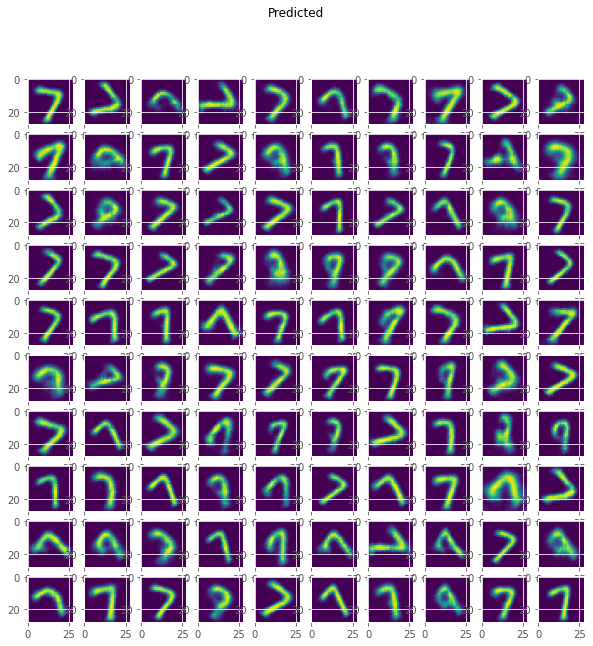

In [ ]:
preds = []
# with torch.no_grad():
# for i, data in tqdm(enumerate(valid_dataloader), total=int(len(valid_dataset)/valid_dataloader.batch_size)):
#     if(torch.cuda.is_available()):
#         data =  data.float().to(device)
#     else:
#         data = data.float()
#     reconstructed_data, mu, logvar = model(data)
#     reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0],28,28))
    
fig = plt.figure(figsize=(10,10))
fig.suptitle("Real")
for i in range(100): 
    plt.subplot(10,10,i+1)
    testout = test_data[i]
    plt.imshow(testout)

fig = plt.figure(figsize=(10,10))
fig.suptitle("Predicted")
for i in range(100): 
    plt.subplot(10,10,i+1)
    if(torch.cuda.is_available()):
        data =  torch.tensor(test_data[i]).to(device)
    else:
        data = torch.tensor(test_data[i])
    data = data[np.newaxis, :, :]
    reconstructed_data, mu, logvar = model(data)
    reconstructed_data = reconstructed_data.reshape((28,28))
    
    plt.imshow(reconstructed_data.detach().cpu().numpy())

#### Checking all 5 latent space embeddings to see if any pattern is captured in the input image

In [348]:
count=0
with torch.no_grad():
    for data in valid_dataloader:            
        data = data.cuda()
        pred, mu, logvar = model(data)
        break
print(pred.shape, mu.shape, logvar.shape, data.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 5]) torch.Size([128, 5]) torch.Size([128, 28, 28])


In [349]:
# Sample with mean of 0 and std dev of 1
std_dev = torch.exp(0.5*logvar)
eps = torch.randn_like(std_dev)
latent_vector = mu + (std_dev*eps)
print(latent_vector.shape)

torch.Size([128, 5])


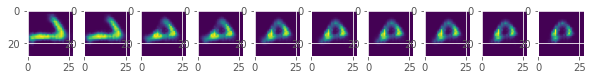

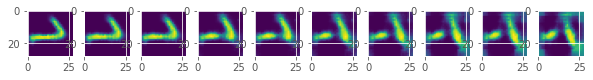

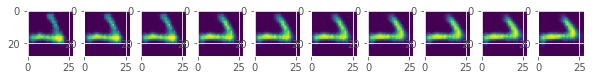

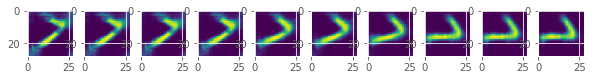

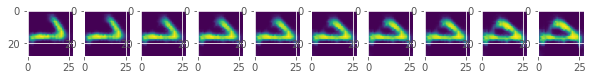

In [353]:
lv = latent_vector[3] # Get first value
vector_sample= lv.repeat(10,1) # repeat it 10 times

for i in range(5): # over all latent dimensions
    vector_sample_cloned = vector_sample.clone()
    vector_sample_cloned[:,i], _ = torch.sort(latent_vector[:10,i]) # keeping other values constant, just make one dimesion with varying values
    with torch.no_grad():
        decoded_output = model.decode(vector_sample_cloned)
        fig = plt.figure(figsize=(10,10))
        for k in range(10): 
            plt.subplot(10,10,k+1)
            show_op = decoded_output[k].reshape((28,28)).cpu()
            plt.imshow(show_op)

torch.Size([9, 1, 28, 28])


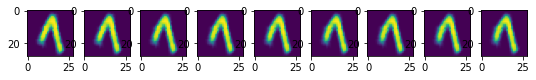

In [54]:
# vector_sample_cloned = vector_sample.clone()
# vector_sample_cloned[:,i] = torch.tensor(np.linspace(-10, 10, 10)) # keeping other values constant, just make one dimesion with varying values


In [354]:
## Effect with rotations and some modifications to the sevens

## Problem 3: Conditional GAN

#### Prepare data

### Inputs for GAN: Random Gaussian Noise vector + Label encoded for Generator. Real Image Flattened vector + Fake Image Flattened vector both with Label encoded for Discriminator

In [487]:
#### KEEP LABELS, IMAGE AND NOISE VECTORS SEPARATELY - AND CONCATENATE DURING FORWARD 

In [48]:
mnist_train = torchvision.datasets.MNIST('mnist',
                train=True,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean = (0.1307), std = (0.3081), inplace = True)
                ]))

mnist_test = torchvision.datasets.MNIST('mnist',
                train=False,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean = (0.1307), std = (0.3081), inplace = True)
                ]))

print('MNIST Train shape', mnist_train.data.shape, type(mnist_train))

MNIST Train shape torch.Size([60000, 28, 28]) <class 'torchvision.datasets.mnist.MNIST'>


In [49]:
# Scale values to range -1 to +1 because of tanh activation used in generator part, and so discriminator can match scales
x_train = (2.*(mnist_train.data)/(255.)) - 1.
x_test = (2.*(mnist_test.data)/(255.)) - 1.


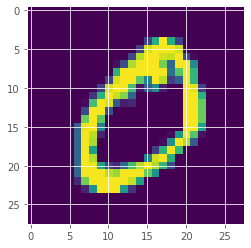

In [50]:
plt.imshow(x_train[1])


In [51]:
y_train = mnist_train.targets
print(y_train.shape)

y_test = mnist_test.targets
print(y_test.shape)


torch.Size([60000])
torch.Size([10000])


In [52]:
# Convert to onehot encoders
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1))
y_test_ohe = ohe.fit_transform(y_test.reshape(-1,1))


In [53]:
y_train_ohe.shape

(60000, 10)

### Why is NOISE necessary? Why not just label encoded vector for generator?:
### Every digit in MNIST has many different shapes. If you remove the noise vector z, then the only input to your generator is the one-hot label (y). So your generator becomes deterministic. It will produce one shape per digit. In other words, your generator is not really a generator anymore, but rather behaves like a simple mapping: 10 digits map to 10 images.Since the generator is limited to producing only 1 out of 10 possible images, then the discriminator job becomes super easy. It manages to differentiate between real and fake images without having to learn higher level semantics, and your training doesn't converge.

###  The generator would for each digit produce an image that is an average of all possible variations of that digit, provided the discriminator gives the generator a reasonable stable feedback.

In [54]:
## Discriminator input
train_real_images = x_train.reshape(x_train.shape[0], 28*28)
test_real_images = x_test.reshape(x_test.shape[0], 28*28)
print('Train real images', train_real_images.shape)
print('Test real images', test_real_images.shape)


Train real images torch.Size([60000, 784])
Test real images torch.Size([10000, 784])


In [12]:
# Dataloader creation
batch_size_train = 128 # batch size train set
batch_size_test = 128 # batch size test set
train_dataset = torch.utils.data.TensorDataset(train_real_images, torch.tensor(y_train_ohe.toarray()) )

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                             batch_size=batch_size_train, 
                                             shuffle=False)


In [21]:
# GAN Model define
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            nn.Linear(110, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Tanh()
        )
        
    def forward(self, x): # x comes with random noise combined with label information (110)
        noise_vector, labels = x
        label_conditioned_noise_vector = torch.hstack((noise_vector, labels))
        fake_generation = self.gen(label_conditioned_noise_vector)
        return fake_generation

        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(794, 400),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(400, 200),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs): # real_x comes with image (794) combined with label information and fake_x just comes with fake images (784) 
        img, labels = inputs
        label_conditioned_img = torch.hstack((img, labels)) # fake_x is now 794
        disc_output = self.disc(label_conditioned_img)
        return disc_output        

def gen_loss(target, fake_generated_outputs, gen_loss_criteria):
    loss = gen_loss_criteria(target, fake_generated_outputs)
    return loss

def disc_loss(target, generated_outputs, disc_loss_criteria):
    loss = disc_loss_critera(target, generated_outputs)
    return loss



# Kaiming He initialization
def he_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)
        
     # Now add for conv layer also
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)
    

In [22]:
# Generator step and discriminator step:
# Steps to train gan: 
# 1. Make disc trainable false, generator model(input) -> disc model(output of gen)
from sklearn.metrics import accuracy_score
# torch.autograd.set_detect_anomaly(True)

def train(generator, discriminator, train_dataloader, disc_optimizer, gen_optimizer, gen_loss_criteria, disc_loss_criteria):
    counter = 0
    running_disc_loss, running_gen_loss = 0, 0

    for i, (real_images, labels) in tqdm(enumerate(train_dataloader)):
        counter+=1
        disc_optimizer.zero_grad()
        if(torch.cuda.is_available()):
            device =  torch.device('cuda')
        else:
            device = "cpu"
        
        real_images = real_images.float().to(device)
        labels = labels.float().to(device)

        # Create target for discriminator (to show real or fake image)
        real_target = torch.ones(real_images.size(0), 1).to(device)
        fake_target = torch.zeros(real_images.size(0), 1).to(device)
        
        # Idea is to pass real image and real labels to disc first, and train it to learn real images. 
        # Then train the discriminator to identify fake images, and then use generator to generate fake images so it can generate better fake images 
        real_disc_output = discriminator((real_images, labels))
        # # Calculate real image prediction accuracy
        results = (real_disc_output.cpu().detach().numpy()>0.5)*1
        real_acc = accuracy_score(results, real_target.cpu().detach().numpy())
        disc_real_loss = disc_loss_criteria(real_disc_output, real_target ) ############ BCELOGITS LOSS
        
        # generate fake images
        noise =  torch.randn(real_images.shape[0], 100).to(device) # 100 dim batch_size noise vector
        fake_image = generator((noise, labels))
        # Save for later use
        # temp_fake_image = fake_image.detach().clone()
        
        fake_disc_output = discriminator((fake_image.detach(), labels)) 
        # # Calculate fake image prediction accuracy
        results = (fake_disc_output.cpu().detach().numpy()>0.5)*1
        fake_acc = accuracy_score(results, fake_target.cpu().detach().numpy())
        disc_fake_loss = disc_loss_criteria(fake_disc_output, fake_target) ############ BCELOGITS LOSS
        
        disc_total_loss = (disc_real_loss + disc_fake_loss)/2
        running_disc_loss += disc_total_loss
        disc_total_loss.backward()
        disc_optimizer.step()
        
        
        # We need to train generator such that it has to get better at generating images so it can fool the discriminator. 
        # So the generator wants the discriminator to predict generated images as real image, and we need to minimize the number of examples the 
        # discriminator classifies correctly as real.
        gen_optimizer.zero_grad()
        disc_op = discriminator((fake_image, labels))
        
        ####### SINCE TANH CAN GIVE -1 TO 1 VALUES, AND BCELOSS ONLY ACCEPTS 0 TO 1 RANGE, I USE SIGMOID OVER TANH FUNCTION
        # gen_total_loss = gen_loss_criteria(torch.sigmoid(disc_op), real_target) ############ BCE LOSS
        gen_total_loss = gen_loss_criteria(disc_op, real_target) ############ BCE LOSS
        running_gen_loss += gen_total_loss
        gen_total_loss.backward()
        gen_optimizer.step()
            
    return running_gen_loss / counter, running_disc_loss / counter, real_acc, fake_acc


In [16]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [23]:
# MSE WITH SIGMOID
if(torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = "cpu"
    
# initialize the model
generator = Generator().float().to(device) # float is useful
discriminator = Discriminator().float().to(device) # float is useful
generator.apply(he_weights) # Goes to optimal values faster
discriminator.apply(he_weights) # Goes to optimal values faster

# set the learning parameters
epochs = 200
batch_size = 128
gen_loss_criteria =  nn.MSELoss() # because of tanh function
disc_loss_criteria = nn.MSELoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
all_disc_loss = []
all_gen_loss = []
all_real_acc = []
all_fake_acc = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    running_gen_loss, running_disc_loss, real_acc, fake_acc = train(generator, discriminator, train_dataloader, disc_optimizer, gen_optimizer, gen_loss_criteria, disc_loss_criteria)    
    all_gen_loss.append(running_gen_loss)
    all_disc_loss.append(running_disc_loss)
    all_real_acc.append(real_acc)
    all_fake_acc.append(fake_acc)    
    
    print(f"Training Disc Loss: {running_disc_loss:.5f}, Gen Loss: {running_gen_loss:.5f}, Real Target Accuracy: {real_acc:.5f}, Fake Target Accuracy: {fake_acc:.5f}")
    # print(f"Validation Loss: {valid_epoch_loss:.5f}")
        

Epoch 1 of 200


469it [00:05, 86.25it/s]


Training Disc Loss: 0.01670, Gen Loss: 0.90381, Real Target Accuracy: 0.93750, Fake Target Accuracy: 0.98958
Epoch 2 of 200


469it [00:04, 103.21it/s]


Training Disc Loss: 0.03332, Gen Loss: 0.90258, Real Target Accuracy: 0.92708, Fake Target Accuracy: 0.97917
Epoch 3 of 200


469it [00:04, 105.02it/s]


Training Disc Loss: 0.03562, Gen Loss: 0.87560, Real Target Accuracy: 0.91667, Fake Target Accuracy: 0.90625
Epoch 4 of 200


469it [00:04, 107.01it/s]


Training Disc Loss: 0.03116, Gen Loss: 0.87166, Real Target Accuracy: 0.94792, Fake Target Accuracy: 1.00000
Epoch 5 of 200


469it [00:04, 106.64it/s]


Training Disc Loss: 0.02843, Gen Loss: 0.89537, Real Target Accuracy: 0.88542, Fake Target Accuracy: 0.97917
Epoch 6 of 200


469it [00:04, 102.86it/s]


Training Disc Loss: 0.03867, Gen Loss: 0.88373, Real Target Accuracy: 0.87500, Fake Target Accuracy: 0.91667
Epoch 7 of 200


469it [00:04, 105.45it/s]


Training Disc Loss: 0.04656, Gen Loss: 0.87012, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.96875
Epoch 8 of 200


469it [00:04, 105.42it/s]


Training Disc Loss: 0.05366, Gen Loss: 0.85725, Real Target Accuracy: 0.88542, Fake Target Accuracy: 0.96875
Epoch 9 of 200


469it [00:04, 105.58it/s]


Training Disc Loss: 0.05042, Gen Loss: 0.85899, Real Target Accuracy: 0.91667, Fake Target Accuracy: 0.96875
Epoch 10 of 200


469it [00:04, 104.29it/s]


Training Disc Loss: 0.05134, Gen Loss: 0.85546, Real Target Accuracy: 0.85417, Fake Target Accuracy: 0.96875
Epoch 11 of 200


469it [00:04, 104.84it/s]


Training Disc Loss: 0.05905, Gen Loss: 0.84549, Real Target Accuracy: 0.80208, Fake Target Accuracy: 0.97917
Epoch 12 of 200


469it [00:04, 104.82it/s]


Training Disc Loss: 0.06364, Gen Loss: 0.82576, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.95833
Epoch 13 of 200


469it [00:04, 104.72it/s]


Training Disc Loss: 0.06557, Gen Loss: 0.81720, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.94792
Epoch 14 of 200


469it [00:04, 107.40it/s]


Training Disc Loss: 0.07032, Gen Loss: 0.80546, Real Target Accuracy: 0.89583, Fake Target Accuracy: 0.97917
Epoch 15 of 200


469it [00:04, 103.92it/s]


Training Disc Loss: 0.07274, Gen Loss: 0.79503, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.93750
Epoch 16 of 200


469it [00:04, 106.15it/s]


Training Disc Loss: 0.07858, Gen Loss: 0.77794, Real Target Accuracy: 0.92708, Fake Target Accuracy: 0.81250
Epoch 17 of 200


469it [00:04, 102.10it/s]


Training Disc Loss: 0.08586, Gen Loss: 0.75925, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.91667
Epoch 18 of 200


469it [00:04, 104.75it/s]


Training Disc Loss: 0.08592, Gen Loss: 0.74459, Real Target Accuracy: 0.87500, Fake Target Accuracy: 0.94792
Epoch 19 of 200


469it [00:04, 105.13it/s]


Training Disc Loss: 0.08115, Gen Loss: 0.76324, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.95833
Epoch 20 of 200


469it [00:04, 103.01it/s]


Training Disc Loss: 0.08176, Gen Loss: 0.76118, Real Target Accuracy: 0.87500, Fake Target Accuracy: 0.94792
Epoch 21 of 200


469it [00:04, 101.87it/s]


Training Disc Loss: 0.08934, Gen Loss: 0.74322, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.83333
Epoch 22 of 200


469it [00:04, 103.84it/s]


Training Disc Loss: 0.09081, Gen Loss: 0.72969, Real Target Accuracy: 0.90625, Fake Target Accuracy: 0.88542
Epoch 23 of 200


469it [00:04, 104.83it/s]


Training Disc Loss: 0.09321, Gen Loss: 0.72367, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.92708
Epoch 24 of 200


469it [00:04, 105.03it/s]


Training Disc Loss: 0.09281, Gen Loss: 0.72005, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.85417
Epoch 25 of 200


469it [00:04, 102.45it/s]


Training Disc Loss: 0.09547, Gen Loss: 0.71586, Real Target Accuracy: 0.93750, Fake Target Accuracy: 0.85417
Epoch 26 of 200


469it [00:04, 105.46it/s]


Training Disc Loss: 0.09802, Gen Loss: 0.70413, Real Target Accuracy: 0.86458, Fake Target Accuracy: 0.80208
Epoch 27 of 200


469it [00:04, 104.29it/s]


Training Disc Loss: 0.10156, Gen Loss: 0.69452, Real Target Accuracy: 0.86458, Fake Target Accuracy: 0.84375
Epoch 28 of 200


469it [00:04, 104.98it/s]


Training Disc Loss: 0.10369, Gen Loss: 0.69022, Real Target Accuracy: 0.88542, Fake Target Accuracy: 0.89583
Epoch 29 of 200


469it [00:04, 103.11it/s]


Training Disc Loss: 0.10470, Gen Loss: 0.68826, Real Target Accuracy: 0.85417, Fake Target Accuracy: 0.83333
Epoch 30 of 200


469it [00:04, 103.64it/s]


Training Disc Loss: 0.10842, Gen Loss: 0.67355, Real Target Accuracy: 0.91667, Fake Target Accuracy: 0.83333
Epoch 31 of 200


469it [00:04, 102.97it/s]


Training Disc Loss: 0.11097, Gen Loss: 0.66918, Real Target Accuracy: 0.85417, Fake Target Accuracy: 0.78125
Epoch 32 of 200


469it [00:04, 103.20it/s]


Training Disc Loss: 0.11545, Gen Loss: 0.65600, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.87500
Epoch 33 of 200


469it [00:04, 103.31it/s]


Training Disc Loss: 0.12041, Gen Loss: 0.64004, Real Target Accuracy: 0.86458, Fake Target Accuracy: 0.85417
Epoch 34 of 200


469it [00:04, 102.17it/s]


Training Disc Loss: 0.12526, Gen Loss: 0.63054, Real Target Accuracy: 0.86458, Fake Target Accuracy: 0.78125
Epoch 35 of 200


469it [00:04, 103.75it/s]


Training Disc Loss: 0.12942, Gen Loss: 0.61372, Real Target Accuracy: 0.93750, Fake Target Accuracy: 0.91667
Epoch 36 of 200


469it [00:04, 103.55it/s]


Training Disc Loss: 0.13533, Gen Loss: 0.59583, Real Target Accuracy: 0.88542, Fake Target Accuracy: 0.77083
Epoch 37 of 200


469it [00:04, 102.59it/s]


Training Disc Loss: 0.13900, Gen Loss: 0.58675, Real Target Accuracy: 0.87500, Fake Target Accuracy: 0.81250
Epoch 38 of 200


469it [00:04, 102.42it/s]


Training Disc Loss: 0.14459, Gen Loss: 0.56869, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.76042
Epoch 39 of 200


469it [00:04, 100.64it/s]


Training Disc Loss: 0.14654, Gen Loss: 0.56261, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.86458
Epoch 40 of 200


469it [00:04, 103.89it/s]


Training Disc Loss: 0.15019, Gen Loss: 0.54774, Real Target Accuracy: 0.87500, Fake Target Accuracy: 0.75000
Epoch 41 of 200


469it [00:04, 102.75it/s]


Training Disc Loss: 0.15363, Gen Loss: 0.54165, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.87500
Epoch 42 of 200


469it [00:04, 102.89it/s]


Training Disc Loss: 0.15817, Gen Loss: 0.52481, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.78125
Epoch 43 of 200


469it [00:04, 103.40it/s]


Training Disc Loss: 0.15972, Gen Loss: 0.52372, Real Target Accuracy: 0.88542, Fake Target Accuracy: 0.79167
Epoch 44 of 200


469it [00:04, 101.71it/s]


Training Disc Loss: 0.16183, Gen Loss: 0.51780, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.78125
Epoch 45 of 200


469it [00:04, 101.87it/s]


Training Disc Loss: 0.16374, Gen Loss: 0.51299, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.84375
Epoch 46 of 200


469it [00:04, 103.30it/s]


Training Disc Loss: 0.16673, Gen Loss: 0.50156, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.80208
Epoch 47 of 200


469it [00:04, 103.21it/s]


Training Disc Loss: 0.16685, Gen Loss: 0.50428, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.76042
Epoch 48 of 200


469it [00:04, 102.20it/s]


Training Disc Loss: 0.16892, Gen Loss: 0.49822, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.77083
Epoch 49 of 200


469it [00:04, 102.53it/s]


Training Disc Loss: 0.17199, Gen Loss: 0.48560, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.88542
Epoch 50 of 200


469it [00:04, 96.99it/s] 


Training Disc Loss: 0.17498, Gen Loss: 0.48100, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.76042
Epoch 51 of 200


469it [00:04, 101.50it/s]


Training Disc Loss: 0.17432, Gen Loss: 0.47794, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.86458
Epoch 52 of 200


469it [00:04, 100.35it/s]


Training Disc Loss: 0.17568, Gen Loss: 0.47370, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.84375
Epoch 53 of 200


469it [00:04, 99.82it/s] 


Training Disc Loss: 0.17744, Gen Loss: 0.47438, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.83333
Epoch 54 of 200


469it [00:04, 100.72it/s]


Training Disc Loss: 0.17966, Gen Loss: 0.46535, Real Target Accuracy: 0.80208, Fake Target Accuracy: 0.83333
Epoch 55 of 200


469it [00:04, 98.79it/s] 


Training Disc Loss: 0.18107, Gen Loss: 0.46072, Real Target Accuracy: 0.80208, Fake Target Accuracy: 0.68750
Epoch 56 of 200


469it [00:04, 102.24it/s]


Training Disc Loss: 0.18414, Gen Loss: 0.45389, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.85417
Epoch 57 of 200


469it [00:04, 100.45it/s]


Training Disc Loss: 0.18356, Gen Loss: 0.45255, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.83333
Epoch 58 of 200


469it [00:04, 98.04it/s] 


Training Disc Loss: 0.18450, Gen Loss: 0.45330, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.71875
Epoch 59 of 200


469it [00:04, 98.57it/s] 


Training Disc Loss: 0.18479, Gen Loss: 0.44895, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.80208
Epoch 60 of 200


469it [00:04, 100.14it/s]


Training Disc Loss: 0.18492, Gen Loss: 0.44708, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.71875
Epoch 61 of 200


469it [00:04, 97.62it/s] 


Training Disc Loss: 0.18755, Gen Loss: 0.44391, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.89583
Epoch 62 of 200


469it [00:04, 102.30it/s]


Training Disc Loss: 0.18960, Gen Loss: 0.43662, Real Target Accuracy: 0.79167, Fake Target Accuracy: 0.84375
Epoch 63 of 200


469it [00:04, 99.51it/s] 


Training Disc Loss: 0.18982, Gen Loss: 0.43378, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.79167
Epoch 64 of 200


469it [00:04, 99.38it/s] 


Training Disc Loss: 0.19068, Gen Loss: 0.43108, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.72917
Epoch 65 of 200


469it [00:04, 100.30it/s]


Training Disc Loss: 0.19103, Gen Loss: 0.43186, Real Target Accuracy: 0.86458, Fake Target Accuracy: 0.81250
Epoch 66 of 200


469it [00:04, 98.45it/s] 


Training Disc Loss: 0.19279, Gen Loss: 0.42736, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.73958
Epoch 67 of 200


469it [00:04, 101.20it/s]


Training Disc Loss: 0.19433, Gen Loss: 0.42140, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.72917
Epoch 68 of 200


469it [00:04, 99.15it/s] 


Training Disc Loss: 0.19528, Gen Loss: 0.41957, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.86458
Epoch 69 of 200


469it [00:04, 99.25it/s] 


Training Disc Loss: 0.19533, Gen Loss: 0.41558, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.81250
Epoch 70 of 200


469it [00:04, 97.58it/s] 


Training Disc Loss: 0.19508, Gen Loss: 0.41987, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.81250
Epoch 71 of 200


469it [00:04, 99.64it/s] 


Training Disc Loss: 0.19736, Gen Loss: 0.41338, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.81250
Epoch 72 of 200


469it [00:04, 99.48it/s] 


Training Disc Loss: 0.19793, Gen Loss: 0.41342, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.84375
Epoch 73 of 200


469it [00:04, 99.46it/s] 


Training Disc Loss: 0.19882, Gen Loss: 0.41106, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.79167
Epoch 74 of 200


469it [00:04, 96.14it/s]


Training Disc Loss: 0.19958, Gen Loss: 0.40683, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.64583
Epoch 75 of 200


469it [00:04, 97.76it/s] 


Training Disc Loss: 0.20087, Gen Loss: 0.40347, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.73958
Epoch 76 of 200


469it [00:04, 97.96it/s] 


Training Disc Loss: 0.20084, Gen Loss: 0.40209, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.86458
Epoch 77 of 200


469it [00:04, 98.29it/s] 


Training Disc Loss: 0.20135, Gen Loss: 0.40061, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.76042
Epoch 78 of 200


469it [00:04, 97.21it/s]


Training Disc Loss: 0.20032, Gen Loss: 0.40067, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.81250
Epoch 79 of 200


469it [00:04, 97.51it/s] 


Training Disc Loss: 0.20050, Gen Loss: 0.40303, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.77083
Epoch 80 of 200


469it [00:04, 98.98it/s] 


Training Disc Loss: 0.20280, Gen Loss: 0.39732, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.88542
Epoch 81 of 200


469it [00:04, 95.94it/s] 


Training Disc Loss: 0.20249, Gen Loss: 0.39411, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.77083
Epoch 82 of 200


469it [00:04, 97.73it/s] 


Training Disc Loss: 0.20293, Gen Loss: 0.39718, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.78125
Epoch 83 of 200


469it [00:04, 95.28it/s]


Training Disc Loss: 0.20337, Gen Loss: 0.39427, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.76042
Epoch 84 of 200


469it [00:04, 96.62it/s]


Training Disc Loss: 0.20441, Gen Loss: 0.39203, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.82292
Epoch 85 of 200


469it [00:04, 96.70it/s]


Training Disc Loss: 0.20456, Gen Loss: 0.38950, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.78125
Epoch 86 of 200


469it [00:04, 95.57it/s]


Training Disc Loss: 0.20482, Gen Loss: 0.38785, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.79167
Epoch 87 of 200


469it [00:04, 97.32it/s] 


Training Disc Loss: 0.20532, Gen Loss: 0.38899, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.68750
Epoch 88 of 200


469it [00:04, 94.07it/s]


Training Disc Loss: 0.20508, Gen Loss: 0.38356, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.63542
Epoch 89 of 200


469it [00:04, 98.13it/s] 


Training Disc Loss: 0.20651, Gen Loss: 0.38484, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.81250
Epoch 90 of 200


469it [00:04, 95.14it/s] 


Training Disc Loss: 0.20531, Gen Loss: 0.38403, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.70833
Epoch 91 of 200


469it [00:04, 96.29it/s]


Training Disc Loss: 0.20748, Gen Loss: 0.38032, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.72917
Epoch 92 of 200


469it [00:04, 94.84it/s] 


Training Disc Loss: 0.20719, Gen Loss: 0.38217, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.80208
Epoch 93 of 200


469it [00:04, 94.54it/s]


Training Disc Loss: 0.20774, Gen Loss: 0.37802, Real Target Accuracy: 0.70833, Fake Target Accuracy: 0.82292
Epoch 94 of 200


469it [00:04, 94.90it/s] 


Training Disc Loss: 0.20756, Gen Loss: 0.38034, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.84375
Epoch 95 of 200


469it [00:04, 95.69it/s]


Training Disc Loss: 0.20664, Gen Loss: 0.38246, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.78125
Epoch 96 of 200


469it [00:04, 95.07it/s]


Training Disc Loss: 0.20797, Gen Loss: 0.37789, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.72917
Epoch 97 of 200


469it [00:04, 95.90it/s] 


Training Disc Loss: 0.20838, Gen Loss: 0.37387, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.68750
Epoch 98 of 200


469it [00:04, 94.87it/s]


Training Disc Loss: 0.20833, Gen Loss: 0.37775, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.66667
Epoch 99 of 200


469it [00:04, 94.79it/s] 


Training Disc Loss: 0.20695, Gen Loss: 0.37981, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.79167
Epoch 100 of 200


469it [00:04, 95.95it/s]


Training Disc Loss: 0.20833, Gen Loss: 0.37946, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.72917
Epoch 101 of 200


469it [00:04, 93.84it/s]


Training Disc Loss: 0.20880, Gen Loss: 0.37326, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.79167
Epoch 102 of 200


469it [00:04, 93.84it/s]


Training Disc Loss: 0.20847, Gen Loss: 0.37692, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.78125
Epoch 103 of 200


469it [00:05, 93.80it/s]


Training Disc Loss: 0.21068, Gen Loss: 0.37297, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.73958
Epoch 104 of 200


469it [00:04, 93.84it/s]


Training Disc Loss: 0.20948, Gen Loss: 0.37469, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.81250
Epoch 105 of 200


469it [00:05, 92.53it/s]


Training Disc Loss: 0.21003, Gen Loss: 0.37265, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.56250
Epoch 106 of 200


469it [00:05, 92.60it/s]


Training Disc Loss: 0.20931, Gen Loss: 0.37120, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.73958
Epoch 107 of 200


469it [00:05, 90.80it/s]


Training Disc Loss: 0.21052, Gen Loss: 0.37061, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.71875
Epoch 108 of 200


469it [00:05, 92.71it/s]


Training Disc Loss: 0.20987, Gen Loss: 0.36818, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.81250
Epoch 109 of 200


469it [00:05, 91.55it/s]


Training Disc Loss: 0.21014, Gen Loss: 0.37138, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.80208
Epoch 110 of 200


469it [00:05, 93.37it/s]


Training Disc Loss: 0.21127, Gen Loss: 0.36603, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.73958
Epoch 111 of 200


469it [00:05, 92.29it/s]


Training Disc Loss: 0.21045, Gen Loss: 0.36808, Real Target Accuracy: 0.80208, Fake Target Accuracy: 0.73958
Epoch 112 of 200


469it [00:05, 91.79it/s]


Training Disc Loss: 0.20997, Gen Loss: 0.37056, Real Target Accuracy: 0.89583, Fake Target Accuracy: 0.69792
Epoch 113 of 200


469it [00:05, 92.48it/s]


Training Disc Loss: 0.21117, Gen Loss: 0.36677, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.73958
Epoch 114 of 200


469it [00:05, 92.46it/s]


Training Disc Loss: 0.21198, Gen Loss: 0.36580, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.75000
Epoch 115 of 200


469it [00:05, 90.99it/s]


Training Disc Loss: 0.21054, Gen Loss: 0.36890, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.77083
Epoch 116 of 200


469it [00:05, 89.80it/s]


Training Disc Loss: 0.21066, Gen Loss: 0.37074, Real Target Accuracy: 0.83333, Fake Target Accuracy: 0.68750
Epoch 117 of 200


469it [00:05, 90.67it/s]


Training Disc Loss: 0.21190, Gen Loss: 0.36484, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.69792
Epoch 118 of 200


469it [00:05, 89.99it/s]


Training Disc Loss: 0.21152, Gen Loss: 0.36554, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.73958
Epoch 119 of 200


469it [00:05, 90.51it/s]


Training Disc Loss: 0.21130, Gen Loss: 0.36748, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.77083
Epoch 120 of 200


469it [00:05, 91.02it/s]


Training Disc Loss: 0.21236, Gen Loss: 0.36454, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.69792
Epoch 121 of 200


469it [00:05, 91.30it/s]


Training Disc Loss: 0.21196, Gen Loss: 0.36384, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.76042
Epoch 122 of 200


469it [00:05, 89.17it/s]


Training Disc Loss: 0.21215, Gen Loss: 0.36392, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.79167
Epoch 123 of 200


469it [00:05, 89.99it/s]


Training Disc Loss: 0.21265, Gen Loss: 0.36257, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.79167
Epoch 124 of 200


469it [00:05, 89.22it/s]


Training Disc Loss: 0.21271, Gen Loss: 0.36460, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.76042
Epoch 125 of 200


469it [00:05, 91.11it/s]


Training Disc Loss: 0.21141, Gen Loss: 0.36315, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.83333
Epoch 126 of 200


469it [00:05, 89.24it/s]


Training Disc Loss: 0.21185, Gen Loss: 0.36573, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.77083
Epoch 127 of 200


469it [00:05, 88.59it/s]


Training Disc Loss: 0.21319, Gen Loss: 0.36359, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.64583
Epoch 128 of 200


469it [00:05, 89.18it/s]


Training Disc Loss: 0.21189, Gen Loss: 0.36398, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.78125
Epoch 129 of 200


469it [00:05, 90.58it/s]


Training Disc Loss: 0.21367, Gen Loss: 0.36101, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.75000
Epoch 130 of 200


469it [00:05, 91.03it/s]


Training Disc Loss: 0.21380, Gen Loss: 0.35970, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.66667
Epoch 131 of 200


469it [00:05, 88.57it/s]


Training Disc Loss: 0.21237, Gen Loss: 0.36207, Real Target Accuracy: 0.80208, Fake Target Accuracy: 0.79167
Epoch 132 of 200


469it [00:05, 88.34it/s]


Training Disc Loss: 0.21359, Gen Loss: 0.35998, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.70833
Epoch 133 of 200


469it [00:05, 88.47it/s]


Training Disc Loss: 0.21301, Gen Loss: 0.36052, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.75000
Epoch 134 of 200


469it [00:05, 88.39it/s]


Training Disc Loss: 0.21232, Gen Loss: 0.36103, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.79167
Epoch 135 of 200


469it [00:05, 88.24it/s]


Training Disc Loss: 0.21409, Gen Loss: 0.35922, Real Target Accuracy: 0.70833, Fake Target Accuracy: 0.83333
Epoch 136 of 200


469it [00:05, 87.08it/s]


Training Disc Loss: 0.21372, Gen Loss: 0.35987, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.84375
Epoch 137 of 200


469it [00:05, 88.60it/s]


Training Disc Loss: 0.21321, Gen Loss: 0.36024, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.83333
Epoch 138 of 200


469it [00:05, 87.77it/s]


Training Disc Loss: 0.21291, Gen Loss: 0.35818, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.61458
Epoch 139 of 200


469it [00:05, 87.13it/s]


Training Disc Loss: 0.21374, Gen Loss: 0.36103, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.75000
Epoch 140 of 200


469it [00:05, 88.18it/s]


Training Disc Loss: 0.21333, Gen Loss: 0.35937, Real Target Accuracy: 0.79167, Fake Target Accuracy: 0.72917
Epoch 141 of 200


469it [00:05, 87.51it/s]


Training Disc Loss: 0.21312, Gen Loss: 0.36161, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.76042
Epoch 142 of 200


469it [00:05, 88.36it/s]


Training Disc Loss: 0.21424, Gen Loss: 0.35764, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.64583
Epoch 143 of 200


469it [00:05, 87.54it/s]


Training Disc Loss: 0.21371, Gen Loss: 0.35704, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.71875
Epoch 144 of 200


469it [00:05, 88.47it/s]


Training Disc Loss: 0.21278, Gen Loss: 0.36005, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.70833
Epoch 145 of 200


469it [00:05, 85.91it/s]


Training Disc Loss: 0.21547, Gen Loss: 0.35829, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.61458
Epoch 146 of 200


469it [00:05, 87.17it/s]


Training Disc Loss: 0.21509, Gen Loss: 0.35509, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.79167
Epoch 147 of 200


469it [00:05, 85.92it/s]


Training Disc Loss: 0.21446, Gen Loss: 0.35578, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.80208
Epoch 148 of 200


469it [00:05, 86.20it/s]


Training Disc Loss: 0.21429, Gen Loss: 0.35718, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.82292
Epoch 149 of 200


469it [00:05, 86.08it/s]


Training Disc Loss: 0.21529, Gen Loss: 0.35518, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.82292
Epoch 150 of 200


469it [00:05, 86.33it/s]


Training Disc Loss: 0.21573, Gen Loss: 0.35250, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.69792
Epoch 151 of 200


469it [00:05, 88.07it/s]


Training Disc Loss: 0.21462, Gen Loss: 0.35613, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.71875
Epoch 152 of 200


469it [00:05, 87.24it/s]


Training Disc Loss: 0.21431, Gen Loss: 0.35620, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.85417
Epoch 153 of 200


469it [00:05, 86.50it/s]


Training Disc Loss: 0.21585, Gen Loss: 0.35388, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.75000
Epoch 154 of 200


469it [00:05, 83.88it/s]


Training Disc Loss: 0.21498, Gen Loss: 0.35548, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.81250
Epoch 155 of 200


469it [00:05, 85.67it/s]


Training Disc Loss: 0.21538, Gen Loss: 0.35253, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.80208
Epoch 156 of 200


469it [00:05, 85.22it/s]


Training Disc Loss: 0.21494, Gen Loss: 0.35381, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.84375
Epoch 157 of 200


469it [00:05, 84.65it/s]


Training Disc Loss: 0.21560, Gen Loss: 0.35099, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.88542
Epoch 158 of 200


469it [00:05, 85.55it/s]


Training Disc Loss: 0.21664, Gen Loss: 0.35097, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.66667
Epoch 159 of 200


469it [00:05, 85.35it/s]


Training Disc Loss: 0.21643, Gen Loss: 0.35142, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.73958
Epoch 160 of 200


469it [00:05, 84.58it/s]


Training Disc Loss: 0.21602, Gen Loss: 0.35178, Real Target Accuracy: 0.70833, Fake Target Accuracy: 0.79167
Epoch 161 of 200


469it [00:05, 84.82it/s]


Training Disc Loss: 0.21713, Gen Loss: 0.34851, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.68750
Epoch 162 of 200


469it [00:05, 84.82it/s]


Training Disc Loss: 0.21550, Gen Loss: 0.35109, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.79167
Epoch 163 of 200


469it [00:05, 85.20it/s]


Training Disc Loss: 0.21671, Gen Loss: 0.35196, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.69792
Epoch 164 of 200


469it [00:05, 84.41it/s]


Training Disc Loss: 0.21670, Gen Loss: 0.34944, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.78125
Epoch 165 of 200


469it [00:05, 83.57it/s]


Training Disc Loss: 0.21690, Gen Loss: 0.34789, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.75000
Epoch 166 of 200


469it [00:05, 83.70it/s]


Training Disc Loss: 0.21633, Gen Loss: 0.35022, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.77083
Epoch 167 of 200


469it [00:05, 83.18it/s]


Training Disc Loss: 0.21627, Gen Loss: 0.35359, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.83333
Epoch 168 of 200


469it [00:05, 84.68it/s]


Training Disc Loss: 0.21598, Gen Loss: 0.35111, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.81250
Epoch 169 of 200


469it [00:05, 84.44it/s]


Training Disc Loss: 0.21605, Gen Loss: 0.35063, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.79167
Epoch 170 of 200


469it [00:05, 84.32it/s]


Training Disc Loss: 0.21728, Gen Loss: 0.34983, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.78125
Epoch 171 of 200


469it [00:05, 84.10it/s]


Training Disc Loss: 0.21686, Gen Loss: 0.34902, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.78125
Epoch 172 of 200


469it [00:05, 83.96it/s]


Training Disc Loss: 0.21739, Gen Loss: 0.34993, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.70833
Epoch 173 of 200


469it [00:05, 83.67it/s]


Training Disc Loss: 0.21663, Gen Loss: 0.34972, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.82292
Epoch 174 of 200


469it [00:05, 84.11it/s]


Training Disc Loss: 0.21729, Gen Loss: 0.34719, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.75000
Epoch 175 of 200


469it [00:05, 81.84it/s]


Training Disc Loss: 0.21757, Gen Loss: 0.34710, Real Target Accuracy: 0.70833, Fake Target Accuracy: 0.76042
Epoch 176 of 200


469it [00:05, 83.27it/s]


Training Disc Loss: 0.21769, Gen Loss: 0.35063, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.61458
Epoch 177 of 200


469it [00:05, 82.12it/s]


Training Disc Loss: 0.21851, Gen Loss: 0.34546, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.69792
Epoch 178 of 200


469it [00:05, 81.10it/s]


Training Disc Loss: 0.21767, Gen Loss: 0.34550, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.82292
Epoch 179 of 200


469it [00:05, 82.58it/s]


Training Disc Loss: 0.21818, Gen Loss: 0.34412, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.68750
Epoch 180 of 200


469it [00:05, 82.32it/s]


Training Disc Loss: 0.21726, Gen Loss: 0.34489, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.76042
Epoch 181 of 200


469it [00:05, 82.98it/s]


Training Disc Loss: 0.21789, Gen Loss: 0.34830, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.66667
Epoch 182 of 200


469it [00:05, 82.72it/s]


Training Disc Loss: 0.21884, Gen Loss: 0.34501, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.76042
Epoch 183 of 200


469it [00:05, 82.75it/s]


Training Disc Loss: 0.21796, Gen Loss: 0.34734, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.72917
Epoch 184 of 200


469it [00:05, 80.30it/s]


Training Disc Loss: 0.21775, Gen Loss: 0.34732, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.68750
Epoch 185 of 200


469it [00:05, 81.42it/s]


Training Disc Loss: 0.21758, Gen Loss: 0.34489, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.72917
Epoch 186 of 200


469it [00:05, 81.89it/s]


Training Disc Loss: 0.21774, Gen Loss: 0.34810, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.78125
Epoch 187 of 200


469it [00:05, 82.06it/s]


Training Disc Loss: 0.21754, Gen Loss: 0.34476, Real Target Accuracy: 0.73958, Fake Target Accuracy: 0.75000
Epoch 188 of 200


469it [00:05, 80.97it/s]


Training Disc Loss: 0.21905, Gen Loss: 0.34313, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.77083
Epoch 189 of 200


469it [00:05, 81.90it/s]


Training Disc Loss: 0.21807, Gen Loss: 0.34405, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.70833
Epoch 190 of 200


469it [00:05, 80.48it/s]


Training Disc Loss: 0.21865, Gen Loss: 0.34507, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.71875
Epoch 191 of 200


469it [00:05, 81.90it/s]


Training Disc Loss: 0.21753, Gen Loss: 0.34607, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.69792
Epoch 192 of 200


469it [00:05, 81.01it/s]


Training Disc Loss: 0.21841, Gen Loss: 0.34730, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.79167
Epoch 193 of 200


469it [00:05, 81.45it/s]


Training Disc Loss: 0.21901, Gen Loss: 0.34246, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.62500
Epoch 194 of 200


469it [00:05, 80.51it/s]


Training Disc Loss: 0.21860, Gen Loss: 0.34345, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.71875
Epoch 195 of 200


469it [00:05, 81.74it/s]


Training Disc Loss: 0.21906, Gen Loss: 0.34337, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.63542
Epoch 196 of 200


469it [00:05, 81.04it/s]


Training Disc Loss: 0.21863, Gen Loss: 0.34196, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.71875
Epoch 197 of 200


469it [00:05, 80.90it/s]


Training Disc Loss: 0.21903, Gen Loss: 0.34267, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.68750
Epoch 198 of 200


469it [00:05, 80.89it/s]


Training Disc Loss: 0.21964, Gen Loss: 0.34197, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.76042
Epoch 199 of 200


469it [00:05, 81.42it/s]


Training Disc Loss: 0.21899, Gen Loss: 0.34135, Real Target Accuracy: 0.79167, Fake Target Accuracy: 0.61458
Epoch 200 of 200


469it [00:05, 78.85it/s]

Training Disc Loss: 0.21801, Gen Loss: 0.34339, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.86458


### Discriminator consist of two loss parts (1st: detect real image as real; 2nd detect fake image as fake). 'Full discriminator loss' is sum of these two parts. The loss should be as small as possible for both the generator and the discriminator. But there is a catch: the smaller the discriminator loss becomes, the more the generator loss increases and vice versa. Discriminator loss: Ideally the full discriminator's loss should be around 0.5 for one instance, which would mean the discriminator is GUESSING whether the image is real or fake (e.g. the same as coin toss: you try to guess is it a tail or a head). Generator loss: Ultimately it should decrease over the next epoch (important: we should choose the optimal number of epoch so as not to overfit our a neural network).

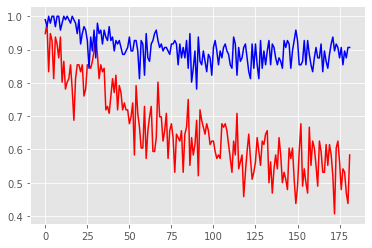

In [85]:
# Plot real and fake accuracy curve
plt.plot(np.arange(182), all_real_acc, c='red')
plt.plot(np.arange(182), all_fake_acc, c='blue')
plt.show() # With BCE and BCELogits loss - they diverge. No Nash Eq.

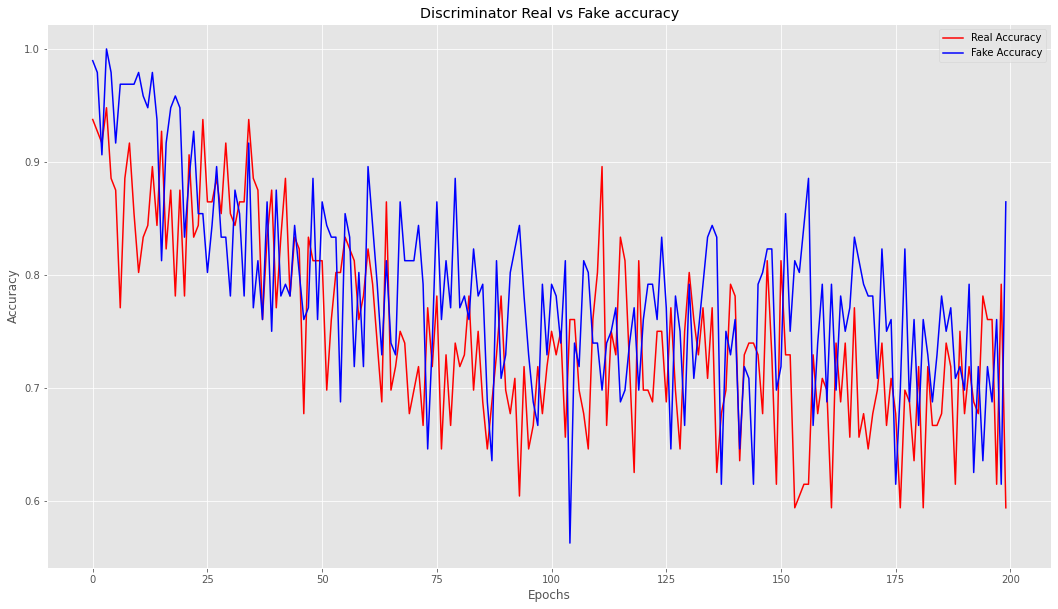

In [45]:
# mse with sigmoid
fig = plt.figure(figsize=(18, 10))
plt.plot(np.arange(epochs), all_real_acc, c='red', label = 'Real Accuracy')
plt.plot(np.arange(epochs), all_fake_acc, c='blue', label = 'Fake Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator Real vs Fake accuracy')
plt.show()

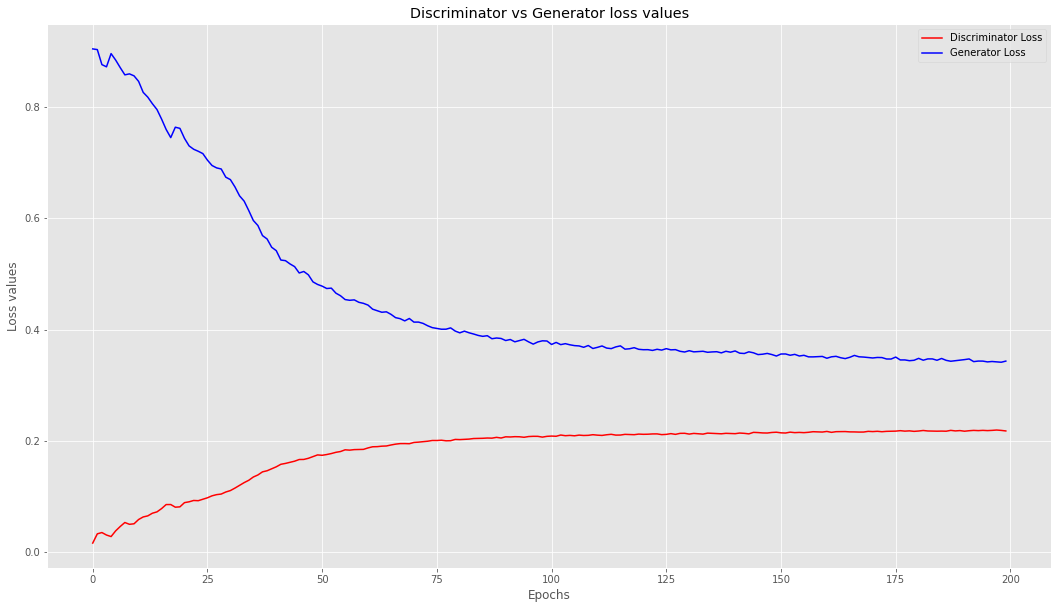

In [37]:
# mse with sigmoid
all_disc_loss_np = []
for i in all_disc_loss:
    all_disc_loss_np.append(i.item())

all_gen_loss_np = []
for i in all_gen_loss:
    all_gen_loss_np.append(i.item())

# Plot real and fake accuracy curve
fig = plt.figure(figsize=(18, 10))
plt.plot(np.arange(epochs), all_disc_loss_np, c='red', label = 'Discriminator Loss')
plt.plot(np.arange(epochs), all_gen_loss_np, c='blue', label = 'Generator Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Discriminator vs Generator loss values')
plt.show()

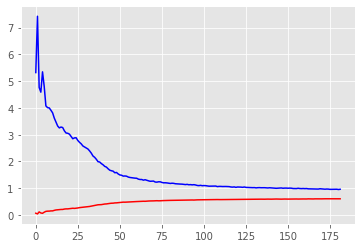

In [87]:
all_disc_loss_np = []
for i in all_disc_loss:
    all_disc_loss_np.append(i.item())

all_gen_loss_np = []
for i in all_gen_loss:
    all_gen_loss_np.append(i.item())

# Plot real and fake accuracy curve
plt.plot(np.arange(182), all_disc_loss_np, c='red')
plt.plot(np.arange(182), all_gen_loss_np, c='blue')
plt.show()

#### Generating images for digits with cgan

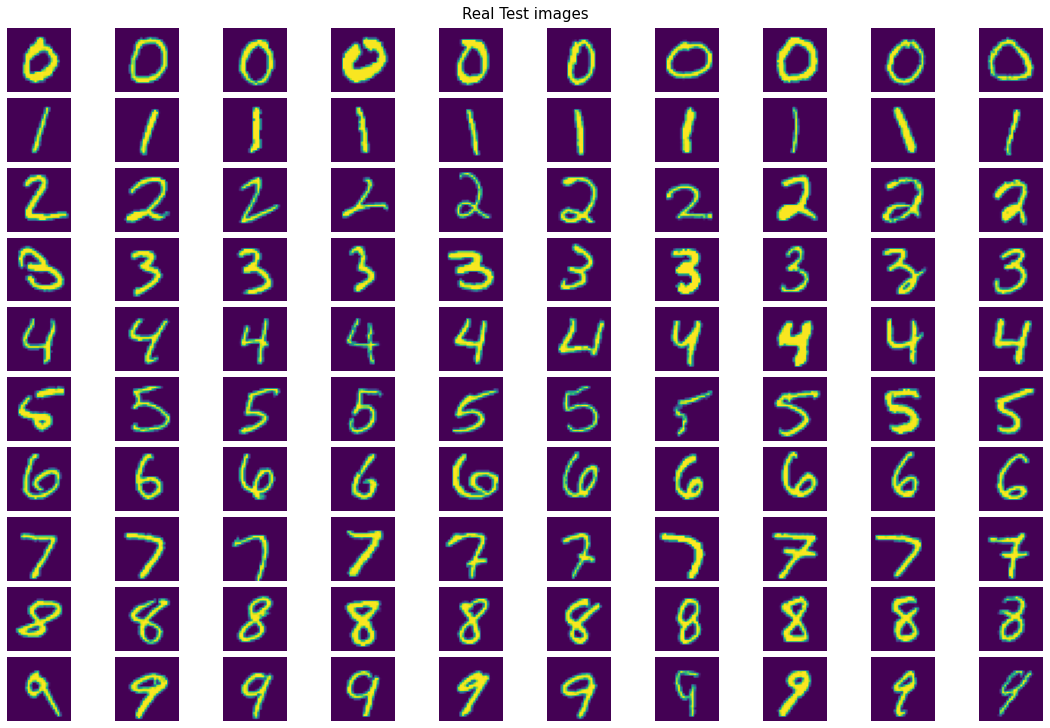

In [76]:
fig, ax = plt.subplots(10, 10, figsize = (15,10), constrained_layout=True)
fig.suptitle('Real Test images', fontsize=15)
for i in range(10):
    real_img = x_test[np.where(y_test == i)][:10]
    for j in range(10):        
        ax[i,j].imshow(real_img[j].reshape(28, 28))
        ax[i,j].axis('off')
    

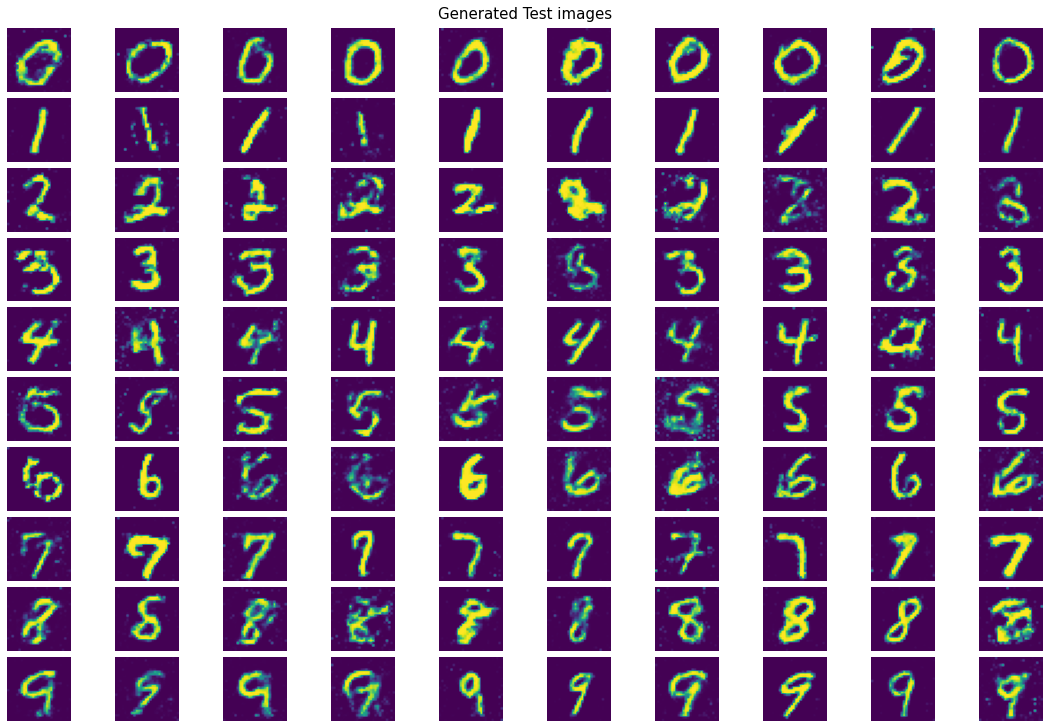

In [77]:
fig, ax = plt.subplots(10, 10, figsize = (15,10), constrained_layout=True)
fig.suptitle('Generated Test images', fontsize=15)
for i in range(10):
    # generate fake images
    ix = np.where(y_test == i)
    labels = torch.tensor(y_test_ohe[ix].toarray()[:10]).float().to(device)
    noise =  torch.randn(10, 100).float().to(device) # 100 dim batch_size noise vector
    fake_image = generator((noise, labels))
    for j in range(10):        
        ax[i,j].imshow(fake_image[j].detach().cpu().numpy().reshape(28, 28))
        ax[i,j].axis('off')

In [83]:
# torch.save(generator.state_dict(), 'Q3_CGAN_Generator')
# torch.save(discriminator.state_dict(), 'Q3_CGAN_Discriminator')

## Problem 4: Missing Value Imputation using CGANs

In [ ]:
# VOCAB OF POSSIBLE VISUALS, TRYING DIFFERENT THINGS.
# Beign able to choose good visual.
# And keep repeating with different features and variables and check patterns - identify why some visual is not best and choose a better visual.



In [84]:
mnist_train = torchvision.datasets.MNIST('mnist',
                train=True,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean = (0.1307), std = (0.3081), inplace = True)
                ]))

mnist_test = torchvision.datasets.MNIST('mnist',
                train=False,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean = (0.1307), std = (0.3081), inplace = True)
                ]))

print('MNIST Train shape', mnist_train.data.shape, type(mnist_train))

# Scale values to range -1 to +1 because of tanh activation used in generator part, and so discriminator can match scales
x_train = (2.*(mnist_train.data)/(255.)) - 1.
x_test = (2.*(mnist_test.data)/(255.)) - 1.

y_train = mnist_train.targets
y_test = mnist_test.targets
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1))
y_test_ohe = ohe.fit_transform(y_test.reshape(-1,1))


MNIST Train shape torch.Size([60000, 28, 28]) <class 'torchvision.datasets.mnist.MNIST'>


In [85]:
# # Modify the image dataset - take center patch and make it into a vector
x_train_center = x_train[:, 10:20, 10:20]
x_test_center = x_test[:, 10:20, 10:20]
print(x_train_center.shape, x_test_center.shape)

torch.Size([60000, 10, 10]) torch.Size([10000, 10, 10])


In [86]:
train_real_images = x_train.reshape(x_train.shape[0], 28*28)
test_real_images = x_test.reshape(x_test.shape[0], 28*28)
train_center_real_images = x_train_center.reshape(x_train_center.shape[0], 100)
test_center_real_images = x_test_center.reshape(x_test_center.shape[0], 100)

print('Train real images', train_real_images.shape, train_center_real_images.shape)
print('Test real images', test_real_images.shape, test_center_real_images.shape)


Train real images torch.Size([60000, 784]) torch.Size([60000, 100])
Test real images torch.Size([10000, 784]) torch.Size([10000, 100])


In [87]:
# Dataloader creation
batch_size_train = 128 # batch size train set
batch_size_test = 128 # batch size test set
train_dataset = torch.utils.data.TensorDataset(train_real_images, train_center_real_images)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                             batch_size=batch_size_train, 
                                             shuffle=False)


In [88]:
# GAN Model define
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 600),
            nn.ReLU(),
            nn.Linear(600, 784),
            nn.Tanh()
        )
        
    def forward(self, x):
        noise_vector, patch_vector = x
        patch_conditioned_noise_vector = torch.hstack((noise_vector, patch_vector))
        fake_generation = self.gen(patch_conditioned_noise_vector)
        return fake_generation

        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(784, 400), # no more label conditioned input, so size changes
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(400, 200),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs):
        disc_output = self.disc(inputs) # no label conditioning, only generated image is input
        return disc_output        


# Kaiming He initialization
def he_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)
        
     # Now add for conv layer also
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)
    

In [134]:
from sklearn.metrics import accuracy_score

def train(generator, discriminator, train_dataloader, disc_optimizer, gen_optimizer, gen_loss_criteria, disc_loss_criteria, lambda_val):
    counter = 0
    running_disc_loss, running_gen_loss = 0, 0

    for i, (real_images, patch_vector) in tqdm(enumerate(train_dataloader)):
        counter+=1
        disc_optimizer.zero_grad()
        if(torch.cuda.is_available()):
            device =  torch.device('cuda')
        else:
            device = "cpu"
        
        real_images = real_images.float().to(device)
        patch_vector = patch_vector.float().to(device)

        real_target = torch.ones(real_images.size(0), 1).to(device)
        fake_target = torch.zeros(real_images.size(0), 1).to(device)
        
        real_disc_output = discriminator(real_images)
        results = (real_disc_output.cpu().detach().numpy()>0.5)*1
        real_acc = accuracy_score(results, real_target.cpu().detach().numpy())
        disc_real_loss = disc_loss_criteria(real_disc_output, real_target ) ############
        
        # generate fake images
        noise =  torch.randn(real_images.shape[0], 100).to(device) # 100 dim batch_size noise vector
        fake_image = generator((noise, patch_vector))
        fake_disc_output = discriminator(fake_image.detach())
        results = (fake_disc_output.cpu().detach().numpy()>0.5)*1
        fake_acc = accuracy_score(results, fake_target.cpu().detach().numpy())
        disc_fake_loss = disc_loss_criteria(fake_disc_output, fake_target) ############
        
        disc_total_loss = (disc_real_loss + disc_fake_loss)/2
        running_disc_loss += disc_total_loss
        disc_total_loss.backward()
        disc_optimizer.step()
        
        gen_optimizer.zero_grad()
        disc_op = discriminator(fake_image)        
        gen_total_loss = gen_loss_criteria(disc_op, real_target) ############ 
        
        # Additional loss term - for regularizing generator to penalize for difference in conditioning vector and center patch of the generated image
        gen_center_image = fake_image.reshape(-1, 28, 28)[:, 10:20, 10:20] # 28x28 gen image
        gen_center_image = gen_center_image.reshape(-1, 100)
        gen_total_loss += lambda_val + torch.mean( (gen_center_image - patch_vector)**2 )
        running_gen_loss += gen_total_loss
        gen_total_loss.backward()
        gen_optimizer.step()
            
    return running_gen_loss / counter, running_disc_loss / counter, real_acc, fake_acc


In [135]:
# MSE WITH SIGMOID AND LAMBDA_VAL = 0.1
if(torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = "cpu"
    
# initialize the model
generator = Generator().float().to(device) # float is useful
discriminator = Discriminator().float().to(device) # float is useful
generator.apply(he_weights) # Goes to optimal values faster
discriminator.apply(he_weights) # Goes to optimal values faster

# set the learning parameters
epochs = 200 # at 10 it becomes zero very early
batch_size = 128
gen_loss_criteria =  nn.MSELoss() # because of tanh function
disc_loss_criteria = nn.MSELoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
all_disc_loss = []
all_gen_loss = []
all_real_acc = []
all_fake_acc = []
lambda_val = 0.1

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    running_gen_loss, running_disc_loss, real_acc, fake_acc = train(generator, discriminator, train_dataloader, disc_optimizer, gen_optimizer, gen_loss_criteria, disc_loss_criteria, lambda_val)    
    all_gen_loss.append(running_gen_loss)
    all_disc_loss.append(running_disc_loss)
    all_real_acc.append(real_acc)
    all_fake_acc.append(fake_acc)    
    
    print(f"Training Disc Loss: {running_disc_loss:.5f}, Gen Loss: {running_gen_loss:.5f}, Real Target Accuracy: {real_acc:.5f}, Fake Target Accuracy: {fake_acc:.5f}")
    # print(f"Validation Loss: {valid_epoch_loss:.5f}")
        

Epoch 1 of 250


469it [00:05, 78.83it/s]


Training Disc Loss: 0.03022, Gen Loss: 11.40084, Real Target Accuracy: 1.00000, Fake Target Accuracy: 0.98958
Epoch 2 of 250


469it [00:04, 93.94it/s] 


Training Disc Loss: 0.01968, Gen Loss: 11.13831, Real Target Accuracy: 0.96875, Fake Target Accuracy: 1.00000
Epoch 3 of 250


469it [00:04, 96.77it/s] 


Training Disc Loss: 0.03383, Gen Loss: 11.07668, Real Target Accuracy: 0.89583, Fake Target Accuracy: 0.79167
Epoch 4 of 250


469it [00:04, 97.78it/s] 


Training Disc Loss: 0.05309, Gen Loss: 11.05130, Real Target Accuracy: 0.96875, Fake Target Accuracy: 0.94792
Epoch 5 of 250


469it [00:04, 97.70it/s] 


Training Disc Loss: 0.07771, Gen Loss: 10.99286, Real Target Accuracy: 0.87500, Fake Target Accuracy: 0.92708
Epoch 6 of 250


469it [00:04, 96.41it/s]


Training Disc Loss: 0.11245, Gen Loss: 10.94608, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.93750
Epoch 7 of 250


469it [00:04, 96.36it/s] 


Training Disc Loss: 0.14663, Gen Loss: 10.83529, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.73958
Epoch 8 of 250


469it [00:04, 98.60it/s] 


Training Disc Loss: 0.15831, Gen Loss: 10.79727, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.60417
Epoch 9 of 250


469it [00:04, 99.87it/s] 


Training Disc Loss: 0.16122, Gen Loss: 10.73782, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.86458
Epoch 10 of 250


469it [00:04, 96.83it/s] 


Training Disc Loss: 0.15817, Gen Loss: 10.73119, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.79167
Epoch 11 of 250


469it [00:04, 99.09it/s] 


Training Disc Loss: 0.17041, Gen Loss: 10.68008, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.69792
Epoch 12 of 250


469it [00:04, 96.56it/s] 


Training Disc Loss: 0.17324, Gen Loss: 10.64412, Real Target Accuracy: 0.79167, Fake Target Accuracy: 0.77083
Epoch 13 of 250


469it [00:04, 95.37it/s] 


Training Disc Loss: 0.17457, Gen Loss: 10.63705, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.78125
Epoch 14 of 250


469it [00:04, 96.90it/s] 


Training Disc Loss: 0.17519, Gen Loss: 10.63204, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.87500
Epoch 15 of 250


469it [00:04, 97.00it/s] 


Training Disc Loss: 0.17816, Gen Loss: 10.61553, Real Target Accuracy: 0.78125, Fake Target Accuracy: 0.77083
Epoch 16 of 250


469it [00:04, 95.83it/s] 


Training Disc Loss: 0.18595, Gen Loss: 10.58877, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.82292
Epoch 17 of 250


469it [00:04, 98.25it/s] 


Training Disc Loss: 0.18563, Gen Loss: 10.56697, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.90625
Epoch 18 of 250


469it [00:04, 97.35it/s] 


Training Disc Loss: 0.18488, Gen Loss: 10.57295, Real Target Accuracy: 0.55208, Fake Target Accuracy: 0.81250
Epoch 19 of 250


469it [00:04, 97.78it/s] 


Training Disc Loss: 0.18710, Gen Loss: 10.58819, Real Target Accuracy: 0.58333, Fake Target Accuracy: 0.82292
Epoch 20 of 250


469it [00:04, 95.00it/s]


Training Disc Loss: 0.19239, Gen Loss: 10.54644, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.76042
Epoch 21 of 250


469it [00:04, 96.98it/s] 


Training Disc Loss: 0.19445, Gen Loss: 10.53148, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.87500
Epoch 22 of 250


469it [00:04, 96.99it/s] 


Training Disc Loss: 0.19577, Gen Loss: 10.52541, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.77083
Epoch 23 of 250


469it [00:04, 94.33it/s]


Training Disc Loss: 0.19247, Gen Loss: 10.52318, Real Target Accuracy: 0.58333, Fake Target Accuracy: 0.75000
Epoch 24 of 250


469it [00:04, 95.77it/s]


Training Disc Loss: 0.20144, Gen Loss: 10.50615, Real Target Accuracy: 0.55208, Fake Target Accuracy: 0.76042
Epoch 25 of 250


469it [00:04, 95.58it/s] 


Training Disc Loss: 0.20217, Gen Loss: 10.50061, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.66667
Epoch 26 of 250


469it [00:04, 95.54it/s]


Training Disc Loss: 0.20442, Gen Loss: 10.48486, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.68750
Epoch 27 of 250


469it [00:04, 94.30it/s]


Training Disc Loss: 0.20834, Gen Loss: 10.47680, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.77083
Epoch 28 of 250


469it [00:04, 95.23it/s]


Training Disc Loss: 0.20807, Gen Loss: 10.46443, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.77083
Epoch 29 of 250


469it [00:05, 92.05it/s]


Training Disc Loss: 0.20994, Gen Loss: 10.46223, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.67708
Epoch 30 of 250


469it [00:04, 94.68it/s]


Training Disc Loss: 0.20942, Gen Loss: 10.45899, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.75000
Epoch 31 of 250


469it [00:05, 93.59it/s]


Training Disc Loss: 0.20815, Gen Loss: 10.45980, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.69792
Epoch 32 of 250


469it [00:05, 92.75it/s]


Training Disc Loss: 0.21244, Gen Loss: 10.44223, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.64583
Epoch 33 of 250


469it [00:04, 93.96it/s]


Training Disc Loss: 0.21129, Gen Loss: 10.44736, Real Target Accuracy: 0.42708, Fake Target Accuracy: 0.68750
Epoch 34 of 250


469it [00:05, 93.21it/s]


Training Disc Loss: 0.21637, Gen Loss: 10.43774, Real Target Accuracy: 0.57292, Fake Target Accuracy: 0.80208
Epoch 35 of 250


469it [00:05, 93.51it/s]


Training Disc Loss: 0.21511, Gen Loss: 10.43089, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.79167
Epoch 36 of 250


469it [00:05, 91.67it/s]


Training Disc Loss: 0.21630, Gen Loss: 10.42798, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.70833
Epoch 37 of 250


469it [00:05, 92.78it/s]


Training Disc Loss: 0.21770, Gen Loss: 10.42074, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.61458
Epoch 38 of 250


469it [00:05, 91.11it/s]


Training Disc Loss: 0.21813, Gen Loss: 10.41993, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.67708
Epoch 39 of 250


469it [00:05, 90.59it/s]


Training Disc Loss: 0.21867, Gen Loss: 10.41370, Real Target Accuracy: 0.70833, Fake Target Accuracy: 0.69792
Epoch 40 of 250


469it [00:05, 89.69it/s]


Training Disc Loss: 0.22039, Gen Loss: 10.41170, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.55208
Epoch 41 of 250


469it [00:05, 90.80it/s]


Training Disc Loss: 0.22202, Gen Loss: 10.40712, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.68750
Epoch 42 of 250


469it [00:05, 88.46it/s]


Training Disc Loss: 0.22271, Gen Loss: 10.40123, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.63542
Epoch 43 of 250


469it [00:05, 89.84it/s]


Training Disc Loss: 0.22396, Gen Loss: 10.39678, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.55208
Epoch 44 of 250


469it [00:05, 87.14it/s]


Training Disc Loss: 0.22485, Gen Loss: 10.39040, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.77083
Epoch 45 of 250


469it [00:05, 83.73it/s]


Training Disc Loss: 0.22561, Gen Loss: 10.38212, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.71875
Epoch 46 of 250


469it [00:05, 86.88it/s]


Training Disc Loss: 0.22432, Gen Loss: 10.38459, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.64583
Epoch 47 of 250


469it [00:05, 86.86it/s]


Training Disc Loss: 0.22520, Gen Loss: 10.38769, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.58333
Epoch 48 of 250


469it [00:05, 85.53it/s]


Training Disc Loss: 0.22791, Gen Loss: 10.38078, Real Target Accuracy: 0.44792, Fake Target Accuracy: 0.63542
Epoch 49 of 250


469it [00:05, 86.25it/s]


Training Disc Loss: 0.22584, Gen Loss: 10.38220, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.71875
Epoch 50 of 250


469it [00:05, 86.51it/s]


Training Disc Loss: 0.22699, Gen Loss: 10.37454, Real Target Accuracy: 0.51042, Fake Target Accuracy: 0.57292
Epoch 51 of 250


469it [00:05, 86.68it/s]


Training Disc Loss: 0.22607, Gen Loss: 10.37658, Real Target Accuracy: 0.55208, Fake Target Accuracy: 0.76042
Epoch 52 of 250


469it [00:05, 83.40it/s]


Training Disc Loss: 0.22549, Gen Loss: 10.37273, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.47917
Epoch 53 of 250


469it [00:05, 84.40it/s]


Training Disc Loss: 0.22690, Gen Loss: 10.37262, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.62500
Epoch 54 of 250


469it [00:05, 86.00it/s]


Training Disc Loss: 0.22787, Gen Loss: 10.36982, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.78125
Epoch 55 of 250


469it [00:05, 85.08it/s]


Training Disc Loss: 0.22327, Gen Loss: 10.37503, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.75000
Epoch 56 of 250


469it [00:05, 82.09it/s]


Training Disc Loss: 0.22789, Gen Loss: 10.36987, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.57292
Epoch 57 of 250


469it [00:05, 81.88it/s]


Training Disc Loss: 0.22667, Gen Loss: 10.37112, Real Target Accuracy: 0.45833, Fake Target Accuracy: 0.73958
Epoch 58 of 250


469it [00:05, 83.16it/s]


Training Disc Loss: 0.22776, Gen Loss: 10.36567, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.62500
Epoch 59 of 250


469it [00:05, 82.60it/s]


Training Disc Loss: 0.23120, Gen Loss: 10.37377, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.69792
Epoch 60 of 250


469it [00:05, 82.54it/s]


Training Disc Loss: 0.22668, Gen Loss: 10.35932, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.68750
Epoch 61 of 250


469it [00:05, 83.37it/s]


Training Disc Loss: 0.22830, Gen Loss: 10.36515, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.71875
Epoch 62 of 250


469it [00:05, 82.73it/s]


Training Disc Loss: 0.23031, Gen Loss: 10.35315, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.64583
Epoch 63 of 250


469it [00:05, 82.57it/s]


Training Disc Loss: 0.22821, Gen Loss: 10.36252, Real Target Accuracy: 0.34375, Fake Target Accuracy: 0.83333
Epoch 64 of 250


469it [00:05, 81.58it/s]


Training Disc Loss: 0.22928, Gen Loss: 10.35646, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.71875
Epoch 65 of 250


469it [00:05, 80.46it/s]


Training Disc Loss: 0.22955, Gen Loss: 10.35412, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.63542
Epoch 66 of 250


469it [00:05, 79.87it/s]


Training Disc Loss: 0.23030, Gen Loss: 10.35515, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.60417
Epoch 67 of 250


469it [00:05, 80.72it/s]


Training Disc Loss: 0.23091, Gen Loss: 10.35446, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.64583
Epoch 68 of 250


469it [00:05, 80.63it/s]


Training Disc Loss: 0.23155, Gen Loss: 10.35305, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.70833
Epoch 69 of 250


469it [00:05, 79.78it/s]


Training Disc Loss: 0.23008, Gen Loss: 10.35158, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.62500
Epoch 70 of 250


469it [00:05, 80.31it/s]


Training Disc Loss: 0.23009, Gen Loss: 10.35615, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.64583
Epoch 71 of 250


469it [00:05, 81.27it/s]


Training Disc Loss: 0.23101, Gen Loss: 10.34869, Real Target Accuracy: 0.44792, Fake Target Accuracy: 0.70833
Epoch 72 of 250


469it [00:05, 79.87it/s]


Training Disc Loss: 0.23121, Gen Loss: 10.35251, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.53125
Epoch 73 of 250


469it [00:05, 82.40it/s]


Training Disc Loss: 0.23147, Gen Loss: 10.35570, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.54167
Epoch 74 of 250


469it [00:05, 81.17it/s]


Training Disc Loss: 0.23240, Gen Loss: 10.34264, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.77083
Epoch 75 of 250


469it [00:05, 82.42it/s]


Training Disc Loss: 0.23129, Gen Loss: 10.34833, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.62500
Epoch 76 of 250


469it [00:05, 79.50it/s]


Training Disc Loss: 0.23164, Gen Loss: 10.34819, Real Target Accuracy: 0.55208, Fake Target Accuracy: 0.64583
Epoch 77 of 250


469it [00:05, 79.82it/s]


Training Disc Loss: 0.23105, Gen Loss: 10.34553, Real Target Accuracy: 0.57292, Fake Target Accuracy: 0.70833
Epoch 78 of 250


469it [00:05, 78.90it/s]


Training Disc Loss: 0.23223, Gen Loss: 10.34325, Real Target Accuracy: 0.57292, Fake Target Accuracy: 0.72917
Epoch 79 of 250


469it [00:05, 79.80it/s]


Training Disc Loss: 0.23208, Gen Loss: 10.34693, Real Target Accuracy: 0.47917, Fake Target Accuracy: 0.67708
Epoch 80 of 250


469it [00:05, 78.73it/s]


Training Disc Loss: 0.23120, Gen Loss: 10.34114, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.57292
Epoch 81 of 250


469it [00:05, 79.29it/s]


Training Disc Loss: 0.23243, Gen Loss: 10.34521, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.70833
Epoch 82 of 250


469it [00:05, 78.83it/s]


Training Disc Loss: 0.23277, Gen Loss: 10.34425, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.78125
Epoch 83 of 250


469it [00:05, 78.90it/s]


Training Disc Loss: 0.23297, Gen Loss: 10.34164, Real Target Accuracy: 0.48958, Fake Target Accuracy: 0.66667
Epoch 84 of 250


469it [00:05, 79.24it/s]


Training Disc Loss: 0.23409, Gen Loss: 10.34034, Real Target Accuracy: 0.72917, Fake Target Accuracy: 0.64583
Epoch 85 of 250


469it [00:05, 78.96it/s]


Training Disc Loss: 0.23127, Gen Loss: 10.34060, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.65625
Epoch 86 of 250


469it [00:06, 76.13it/s]


Training Disc Loss: 0.23412, Gen Loss: 10.33978, Real Target Accuracy: 0.57292, Fake Target Accuracy: 0.72917
Epoch 87 of 250


469it [00:05, 78.50it/s]


Training Disc Loss: 0.23412, Gen Loss: 10.33532, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.62500
Epoch 88 of 250


469it [00:06, 78.08it/s]


Training Disc Loss: 0.23370, Gen Loss: 10.33605, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.60417
Epoch 89 of 250


469it [00:06, 77.80it/s]


Training Disc Loss: 0.23397, Gen Loss: 10.33753, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.77083
Epoch 90 of 250


469it [00:06, 77.22it/s]


Training Disc Loss: 0.23394, Gen Loss: 10.33778, Real Target Accuracy: 0.57292, Fake Target Accuracy: 0.64583
Epoch 91 of 250


469it [00:06, 77.42it/s]


Training Disc Loss: 0.23391, Gen Loss: 10.33484, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.69792
Epoch 92 of 250


469it [00:06, 76.74it/s]


Training Disc Loss: 0.23487, Gen Loss: 10.33533, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.71875
Epoch 93 of 250


469it [00:06, 77.71it/s]


Training Disc Loss: 0.23467, Gen Loss: 10.33214, Real Target Accuracy: 0.70833, Fake Target Accuracy: 0.69792
Epoch 94 of 250


469it [00:06, 77.26it/s]


Training Disc Loss: 0.23499, Gen Loss: 10.33593, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.76042
Epoch 95 of 250


469it [00:06, 76.96it/s]


Training Disc Loss: 0.23438, Gen Loss: 10.33428, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.55208
Epoch 96 of 250


469it [00:06, 76.29it/s]


Training Disc Loss: 0.23504, Gen Loss: 10.33407, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.57292
Epoch 97 of 250


469it [00:06, 77.49it/s]


Training Disc Loss: 0.23532, Gen Loss: 10.33080, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.67708
Epoch 98 of 250


469it [00:06, 74.63it/s]


Training Disc Loss: 0.23498, Gen Loss: 10.32957, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.66667
Epoch 99 of 250


469it [00:06, 75.96it/s]


Training Disc Loss: 0.23435, Gen Loss: 10.33299, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.56250
Epoch 100 of 250


469it [00:06, 73.87it/s]


Training Disc Loss: 0.23581, Gen Loss: 10.33039, Real Target Accuracy: 0.38542, Fake Target Accuracy: 0.59375
Epoch 101 of 250


469it [00:06, 76.28it/s]


Training Disc Loss: 0.23552, Gen Loss: 10.32841, Real Target Accuracy: 0.39583, Fake Target Accuracy: 0.67708
Epoch 102 of 250


469it [00:06, 75.67it/s]


Training Disc Loss: 0.23501, Gen Loss: 10.32910, Real Target Accuracy: 0.42708, Fake Target Accuracy: 0.54167
Epoch 103 of 250


469it [00:06, 76.37it/s]


Training Disc Loss: 0.23616, Gen Loss: 10.32911, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.68750
Epoch 104 of 250


469it [00:06, 74.66it/s]


Training Disc Loss: 0.23615, Gen Loss: 10.32729, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.57292
Epoch 105 of 250


469it [00:06, 74.75it/s]


Training Disc Loss: 0.23616, Gen Loss: 10.32516, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.60417
Epoch 106 of 250


469it [00:06, 74.20it/s]


Training Disc Loss: 0.23565, Gen Loss: 10.32710, Real Target Accuracy: 0.57292, Fake Target Accuracy: 0.61458
Epoch 107 of 250


469it [00:06, 75.45it/s]


Training Disc Loss: 0.23624, Gen Loss: 10.32715, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.57292
Epoch 108 of 250


469it [00:06, 73.91it/s]


Training Disc Loss: 0.23660, Gen Loss: 10.32359, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.72917
Epoch 109 of 250


469it [00:06, 74.02it/s]


Training Disc Loss: 0.23668, Gen Loss: 10.32542, Real Target Accuracy: 0.46875, Fake Target Accuracy: 0.68750
Epoch 110 of 250


469it [00:06, 74.17it/s]


Training Disc Loss: 0.23727, Gen Loss: 10.32453, Real Target Accuracy: 0.81250, Fake Target Accuracy: 0.65625
Epoch 111 of 250


469it [00:06, 75.67it/s]


Training Disc Loss: 0.23866, Gen Loss: 10.32125, Real Target Accuracy: 0.32292, Fake Target Accuracy: 0.72917
Epoch 112 of 250


469it [00:06, 73.72it/s]


Training Disc Loss: 0.23525, Gen Loss: 10.32425, Real Target Accuracy: 0.51042, Fake Target Accuracy: 0.63542
Epoch 113 of 250


469it [00:06, 75.43it/s]


Training Disc Loss: 0.23776, Gen Loss: 10.32402, Real Target Accuracy: 0.35417, Fake Target Accuracy: 0.68750
Epoch 114 of 250


469it [00:06, 73.77it/s]


Training Disc Loss: 0.23788, Gen Loss: 10.31879, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.45833
Epoch 115 of 250


469it [00:06, 74.86it/s]


Training Disc Loss: 0.23560, Gen Loss: 10.32315, Real Target Accuracy: 0.31250, Fake Target Accuracy: 0.75000
Epoch 116 of 250


469it [00:06, 72.70it/s]


Training Disc Loss: 0.23715, Gen Loss: 10.32497, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.45833
Epoch 117 of 250


469it [00:06, 74.07it/s]


Training Disc Loss: 0.23789, Gen Loss: 10.31957, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.68750
Epoch 118 of 250


469it [00:06, 72.95it/s]


Training Disc Loss: 0.23858, Gen Loss: 10.31852, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.70833
Epoch 119 of 250


469it [00:06, 72.24it/s]


Training Disc Loss: 0.23639, Gen Loss: 10.32019, Real Target Accuracy: 0.77083, Fake Target Accuracy: 0.61458
Epoch 120 of 250


469it [00:06, 72.99it/s]


Training Disc Loss: 0.23724, Gen Loss: 10.32178, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.51042
Epoch 121 of 250


469it [00:06, 73.57it/s]


Training Disc Loss: 0.23849, Gen Loss: 10.31613, Real Target Accuracy: 0.51042, Fake Target Accuracy: 0.61458
Epoch 122 of 250


469it [00:06, 73.69it/s]


Training Disc Loss: 0.23671, Gen Loss: 10.32118, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.51042
Epoch 123 of 250


469it [00:06, 72.05it/s]


Training Disc Loss: 0.23687, Gen Loss: 10.31853, Real Target Accuracy: 0.58333, Fake Target Accuracy: 0.70833
Epoch 124 of 250


469it [00:06, 70.47it/s]


Training Disc Loss: 0.23817, Gen Loss: 10.32247, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.55208
Epoch 125 of 250


469it [00:06, 71.80it/s]


Training Disc Loss: 0.23804, Gen Loss: 10.31785, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.55208
Epoch 126 of 250


469it [00:06, 69.98it/s]


Training Disc Loss: 0.23799, Gen Loss: 10.31971, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.52083
Epoch 127 of 250


469it [00:06, 72.06it/s]


Training Disc Loss: 0.23736, Gen Loss: 10.31985, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.69792
Epoch 128 of 250


469it [00:06, 71.20it/s]


Training Disc Loss: 0.23842, Gen Loss: 10.31569, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.68750
Epoch 129 of 250


469it [00:06, 72.17it/s]


Training Disc Loss: 0.23872, Gen Loss: 10.31475, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.66667
Epoch 130 of 250


469it [00:06, 71.58it/s]


Training Disc Loss: 0.23777, Gen Loss: 10.31500, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.54167
Epoch 131 of 250


469it [00:06, 71.75it/s]


Training Disc Loss: 0.23902, Gen Loss: 10.31683, Real Target Accuracy: 0.47917, Fake Target Accuracy: 0.75000
Epoch 132 of 250


469it [00:06, 70.48it/s]


Training Disc Loss: 0.23814, Gen Loss: 10.31724, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.63542
Epoch 133 of 250


469it [00:06, 70.40it/s]


Training Disc Loss: 0.23846, Gen Loss: 10.31243, Real Target Accuracy: 0.41667, Fake Target Accuracy: 0.73958
Epoch 134 of 250


469it [00:06, 71.01it/s]


Training Disc Loss: 0.24029, Gen Loss: 10.30980, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.57292
Epoch 135 of 250


469it [00:06, 70.90it/s]


Training Disc Loss: 0.23758, Gen Loss: 10.31335, Real Target Accuracy: 0.47917, Fake Target Accuracy: 0.70833
Epoch 136 of 250


469it [00:06, 70.01it/s]


Training Disc Loss: 0.23925, Gen Loss: 10.31222, Real Target Accuracy: 0.40625, Fake Target Accuracy: 0.68750
Epoch 137 of 250


469it [00:06, 71.03it/s]


Training Disc Loss: 0.23831, Gen Loss: 10.31742, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.68750
Epoch 138 of 250


469it [00:06, 69.49it/s]


Training Disc Loss: 0.24105, Gen Loss: 10.31122, Real Target Accuracy: 0.37500, Fake Target Accuracy: 0.59375
Epoch 139 of 250


469it [00:06, 70.48it/s]


Training Disc Loss: 0.24092, Gen Loss: 10.30937, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.62500
Epoch 140 of 250


469it [00:06, 71.29it/s]


Training Disc Loss: 0.23971, Gen Loss: 10.30652, Real Target Accuracy: 0.35417, Fake Target Accuracy: 0.75000
Epoch 141 of 250


469it [00:06, 70.03it/s]


Training Disc Loss: 0.24194, Gen Loss: 10.30711, Real Target Accuracy: 0.55208, Fake Target Accuracy: 0.65625
Epoch 142 of 250


469it [00:06, 68.06it/s]


Training Disc Loss: 0.24144, Gen Loss: 10.30578, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.47917
Epoch 143 of 250


469it [00:06, 67.11it/s]


Training Disc Loss: 0.23936, Gen Loss: 10.30492, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.72917
Epoch 144 of 250


469it [00:06, 68.45it/s]


Training Disc Loss: 0.23958, Gen Loss: 10.31428, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.57292
Epoch 145 of 250


469it [00:06, 70.24it/s]


Training Disc Loss: 0.24022, Gen Loss: 10.30862, Real Target Accuracy: 0.76042, Fake Target Accuracy: 0.61458
Epoch 146 of 250


469it [00:06, 69.16it/s]


Training Disc Loss: 0.23947, Gen Loss: 10.30749, Real Target Accuracy: 0.30208, Fake Target Accuracy: 0.79167
Epoch 147 of 250


469it [00:06, 70.28it/s]


Training Disc Loss: 0.23826, Gen Loss: 10.31013, Real Target Accuracy: 0.46875, Fake Target Accuracy: 0.61458
Epoch 148 of 250


469it [00:06, 69.03it/s]


Training Disc Loss: 0.23965, Gen Loss: 10.30901, Real Target Accuracy: 0.40625, Fake Target Accuracy: 0.50000
Epoch 149 of 250


469it [00:06, 69.10it/s]


Training Disc Loss: 0.23919, Gen Loss: 10.30996, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.65625
Epoch 150 of 250


469it [00:06, 69.25it/s]


Training Disc Loss: 0.23997, Gen Loss: 10.30784, Real Target Accuracy: 0.55208, Fake Target Accuracy: 0.63542
Epoch 151 of 250


469it [00:06, 67.77it/s]


Training Disc Loss: 0.23839, Gen Loss: 10.30627, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.72917
Epoch 152 of 250


469it [00:06, 67.24it/s]


Training Disc Loss: 0.24013, Gen Loss: 10.30920, Real Target Accuracy: 0.43750, Fake Target Accuracy: 0.79167
Epoch 153 of 250


469it [00:06, 69.83it/s]


Training Disc Loss: 0.24116, Gen Loss: 10.30525, Real Target Accuracy: 0.48958, Fake Target Accuracy: 0.60417
Epoch 154 of 250


469it [00:07, 66.94it/s]


Training Disc Loss: 0.24111, Gen Loss: 10.30673, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.70833
Epoch 155 of 250


469it [00:06, 67.92it/s]


Training Disc Loss: 0.23896, Gen Loss: 10.31449, Real Target Accuracy: 0.58333, Fake Target Accuracy: 0.65625
Epoch 156 of 250


469it [00:06, 67.85it/s]


Training Disc Loss: 0.24032, Gen Loss: 10.30634, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.65625
Epoch 157 of 250


469it [00:06, 67.38it/s]


Training Disc Loss: 0.24182, Gen Loss: 10.30781, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.61458
Epoch 158 of 250


469it [00:06, 67.19it/s]


Training Disc Loss: 0.24137, Gen Loss: 10.30662, Real Target Accuracy: 0.44792, Fake Target Accuracy: 0.60417
Epoch 159 of 250


469it [00:06, 67.81it/s]


Training Disc Loss: 0.24210, Gen Loss: 10.29912, Real Target Accuracy: 0.30208, Fake Target Accuracy: 0.83333
Epoch 160 of 250


469it [00:07, 66.27it/s]


Training Disc Loss: 0.24175, Gen Loss: 10.30196, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.67708
Epoch 161 of 250


469it [00:06, 68.01it/s]


Training Disc Loss: 0.24066, Gen Loss: 10.30342, Real Target Accuracy: 0.58333, Fake Target Accuracy: 0.66667
Epoch 162 of 250


469it [00:07, 66.29it/s]


Training Disc Loss: 0.23888, Gen Loss: 10.30519, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.67708
Epoch 163 of 250


469it [00:07, 66.58it/s]


Training Disc Loss: 0.24201, Gen Loss: 10.30427, Real Target Accuracy: 0.45833, Fake Target Accuracy: 0.62500
Epoch 164 of 250


469it [00:07, 66.36it/s]


Training Disc Loss: 0.23910, Gen Loss: 10.30732, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.55208
Epoch 165 of 250


469it [00:06, 67.44it/s]


Training Disc Loss: 0.24192, Gen Loss: 10.29962, Real Target Accuracy: 0.53125, Fake Target Accuracy: 0.63542
Epoch 166 of 250


469it [00:07, 66.71it/s]


Training Disc Loss: 0.24078, Gen Loss: 10.30528, Real Target Accuracy: 0.47917, Fake Target Accuracy: 0.59375
Epoch 167 of 250


469it [00:06, 67.95it/s]


Training Disc Loss: 0.24216, Gen Loss: 10.30594, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.48958
Epoch 168 of 250


469it [00:07, 65.49it/s]


Training Disc Loss: 0.23987, Gen Loss: 10.30764, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.75000
Epoch 169 of 250


469it [00:07, 66.70it/s]


Training Disc Loss: 0.24006, Gen Loss: 10.30538, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.57292
Epoch 170 of 250


469it [00:07, 65.38it/s]


Training Disc Loss: 0.23989, Gen Loss: 10.30424, Real Target Accuracy: 0.46875, Fake Target Accuracy: 0.69792
Epoch 171 of 250


469it [00:07, 66.66it/s]


Training Disc Loss: 0.23961, Gen Loss: 10.30908, Real Target Accuracy: 0.38542, Fake Target Accuracy: 0.75000
Epoch 172 of 250


469it [00:07, 65.29it/s]


Training Disc Loss: 0.23884, Gen Loss: 10.30931, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.61458
Epoch 173 of 250


469it [00:07, 66.08it/s]


Training Disc Loss: 0.24030, Gen Loss: 10.30356, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.77083
Epoch 174 of 250


469it [00:07, 66.15it/s]


Training Disc Loss: 0.24017, Gen Loss: 10.30867, Real Target Accuracy: 0.37500, Fake Target Accuracy: 0.75000
Epoch 175 of 250


469it [00:07, 66.12it/s]


Training Disc Loss: 0.24097, Gen Loss: 10.30164, Real Target Accuracy: 0.58333, Fake Target Accuracy: 0.66667
Epoch 176 of 250


469it [00:07, 64.14it/s]


Training Disc Loss: 0.24064, Gen Loss: 10.30173, Real Target Accuracy: 0.80208, Fake Target Accuracy: 0.53125
Epoch 177 of 250


469it [00:07, 65.27it/s]


Training Disc Loss: 0.24176, Gen Loss: 10.30238, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.65625
Epoch 178 of 250


469it [00:07, 64.83it/s]


Training Disc Loss: 0.24096, Gen Loss: 10.30357, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.59375
Epoch 179 of 250


469it [00:07, 65.64it/s]


Training Disc Loss: 0.24113, Gen Loss: 10.30250, Real Target Accuracy: 0.80208, Fake Target Accuracy: 0.45833
Epoch 180 of 250


469it [00:07, 64.36it/s]


Training Disc Loss: 0.24053, Gen Loss: 10.30162, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.67708
Epoch 181 of 250


469it [00:07, 64.94it/s]


Training Disc Loss: 0.24383, Gen Loss: 10.29679, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.59375
Epoch 182 of 250


469it [00:07, 64.36it/s]


Training Disc Loss: 0.24292, Gen Loss: 10.29953, Real Target Accuracy: 0.57292, Fake Target Accuracy: 0.47917
Epoch 183 of 250


469it [00:07, 65.73it/s]


Training Disc Loss: 0.24160, Gen Loss: 10.30541, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.58333
Epoch 184 of 250


469it [00:07, 64.04it/s]


Training Disc Loss: 0.24211, Gen Loss: 10.30341, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.57292
Epoch 185 of 250


469it [00:07, 64.62it/s]


Training Disc Loss: 0.24142, Gen Loss: 10.30138, Real Target Accuracy: 0.82292, Fake Target Accuracy: 0.52083
Epoch 186 of 250


469it [00:07, 63.24it/s]


Training Disc Loss: 0.24259, Gen Loss: 10.29630, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.72917
Epoch 187 of 250


469it [00:07, 65.23it/s]


Training Disc Loss: 0.24155, Gen Loss: 10.29719, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.63542
Epoch 188 of 250


469it [00:07, 63.21it/s]


Training Disc Loss: 0.24357, Gen Loss: 10.29773, Real Target Accuracy: 0.48958, Fake Target Accuracy: 0.60417
Epoch 189 of 250


469it [00:07, 63.90it/s]


Training Disc Loss: 0.24158, Gen Loss: 10.29915, Real Target Accuracy: 0.48958, Fake Target Accuracy: 0.76042
Epoch 190 of 250


469it [00:07, 62.93it/s]


Training Disc Loss: 0.24146, Gen Loss: 10.30363, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.52083
Epoch 191 of 250


469it [00:07, 64.67it/s]


Training Disc Loss: 0.24100, Gen Loss: 10.30099, Real Target Accuracy: 0.45833, Fake Target Accuracy: 0.69792
Epoch 192 of 250


469it [00:07, 63.50it/s]


Training Disc Loss: 0.24157, Gen Loss: 10.30218, Real Target Accuracy: 0.48958, Fake Target Accuracy: 0.56250
Epoch 193 of 250


469it [00:07, 64.04it/s]


Training Disc Loss: 0.24347, Gen Loss: 10.30144, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.67708
Epoch 194 of 250


469it [00:07, 62.91it/s]


Training Disc Loss: 0.24424, Gen Loss: 10.29215, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.60417
Epoch 195 of 250


469it [00:07, 63.58it/s]


Training Disc Loss: 0.24244, Gen Loss: 10.30076, Real Target Accuracy: 0.42708, Fake Target Accuracy: 0.77083
Epoch 196 of 250


469it [00:07, 62.79it/s]


Training Disc Loss: 0.24178, Gen Loss: 10.29428, Real Target Accuracy: 0.39583, Fake Target Accuracy: 0.66667
Epoch 197 of 250


469it [00:07, 64.05it/s]


Training Disc Loss: 0.24357, Gen Loss: 10.29899, Real Target Accuracy: 0.44792, Fake Target Accuracy: 0.62500
Epoch 198 of 250


469it [00:07, 63.64it/s]


Training Disc Loss: 0.24165, Gen Loss: 10.29647, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.61458
Epoch 199 of 250


469it [00:07, 63.64it/s]


Training Disc Loss: 0.24353, Gen Loss: 10.29681, Real Target Accuracy: 0.46875, Fake Target Accuracy: 0.85417
Epoch 200 of 250


469it [00:07, 63.29it/s]


Training Disc Loss: 0.24169, Gen Loss: 10.30223, Real Target Accuracy: 0.42708, Fake Target Accuracy: 0.65625
Epoch 201 of 250


469it [00:07, 63.68it/s]


Training Disc Loss: 0.24099, Gen Loss: 10.30466, Real Target Accuracy: 0.32292, Fake Target Accuracy: 0.72917
Epoch 202 of 250


469it [00:07, 61.43it/s]


Training Disc Loss: 0.24219, Gen Loss: 10.29968, Real Target Accuracy: 0.69792, Fake Target Accuracy: 0.53125
Epoch 203 of 250


469it [00:07, 63.52it/s]


Training Disc Loss: 0.24046, Gen Loss: 10.30229, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.62500
Epoch 204 of 250


469it [00:07, 61.87it/s]


Training Disc Loss: 0.24236, Gen Loss: 10.30148, Real Target Accuracy: 0.68750, Fake Target Accuracy: 0.46875
Epoch 205 of 250


469it [00:07, 61.71it/s]


Training Disc Loss: 0.24246, Gen Loss: 10.30008, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.73958
Epoch 206 of 250


469it [00:07, 61.75it/s]


Training Disc Loss: 0.24230, Gen Loss: 10.29752, Real Target Accuracy: 0.71875, Fake Target Accuracy: 0.40625
Epoch 207 of 250


469it [00:08, 56.75it/s]


Training Disc Loss: 0.24415, Gen Loss: 10.29956, Real Target Accuracy: 0.44792, Fake Target Accuracy: 0.69792
Epoch 208 of 250


469it [00:08, 54.36it/s]


Training Disc Loss: 0.24318, Gen Loss: 10.29459, Real Target Accuracy: 0.56250, Fake Target Accuracy: 0.60417
Epoch 209 of 250


469it [00:07, 59.68it/s]


Training Disc Loss: 0.24334, Gen Loss: 10.29758, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.35417
Epoch 210 of 250


469it [00:07, 61.02it/s]


Training Disc Loss: 0.24125, Gen Loss: 10.29683, Real Target Accuracy: 0.47917, Fake Target Accuracy: 0.69792
Epoch 211 of 250


469it [00:07, 62.19it/s]


Training Disc Loss: 0.24420, Gen Loss: 10.29290, Real Target Accuracy: 0.61458, Fake Target Accuracy: 0.53125
Epoch 212 of 250


469it [00:07, 60.69it/s]


Training Disc Loss: 0.24320, Gen Loss: 10.29091, Real Target Accuracy: 0.51042, Fake Target Accuracy: 0.48958
Epoch 213 of 250


469it [00:07, 61.64it/s]


Training Disc Loss: 0.24171, Gen Loss: 10.29634, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.61458
Epoch 214 of 250


469it [00:07, 61.28it/s]


Training Disc Loss: 0.24265, Gen Loss: 10.29633, Real Target Accuracy: 0.55208, Fake Target Accuracy: 0.63542
Epoch 215 of 250


469it [00:07, 62.34it/s]


Training Disc Loss: 0.24205, Gen Loss: 10.29766, Real Target Accuracy: 0.46875, Fake Target Accuracy: 0.66667
Epoch 216 of 250


469it [00:07, 60.01it/s]


Training Disc Loss: 0.24395, Gen Loss: 10.29770, Real Target Accuracy: 0.41667, Fake Target Accuracy: 0.65625
Epoch 217 of 250


469it [00:07, 61.89it/s]


Training Disc Loss: 0.24254, Gen Loss: 10.30063, Real Target Accuracy: 0.47917, Fake Target Accuracy: 0.56250
Epoch 218 of 250


469it [00:07, 60.38it/s]


Training Disc Loss: 0.24339, Gen Loss: 10.29071, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.62500
Epoch 219 of 250


469it [00:07, 61.65it/s]


Training Disc Loss: 0.24175, Gen Loss: 10.29682, Real Target Accuracy: 0.41667, Fake Target Accuracy: 0.65625
Epoch 220 of 250


469it [00:07, 59.89it/s]


Training Disc Loss: 0.24297, Gen Loss: 10.29754, Real Target Accuracy: 0.75000, Fake Target Accuracy: 0.60417
Epoch 221 of 250


469it [00:07, 61.77it/s]


Training Disc Loss: 0.24408, Gen Loss: 10.29571, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.53125
Epoch 222 of 250


469it [00:07, 59.54it/s]


Training Disc Loss: 0.24492, Gen Loss: 10.29414, Real Target Accuracy: 0.42708, Fake Target Accuracy: 0.71875
Epoch 223 of 250


469it [00:07, 60.25it/s]


Training Disc Loss: 0.24023, Gen Loss: 10.30463, Real Target Accuracy: 0.63542, Fake Target Accuracy: 0.58333
Epoch 224 of 250


469it [00:07, 62.03it/s]


Training Disc Loss: 0.24427, Gen Loss: 10.29540, Real Target Accuracy: 0.37500, Fake Target Accuracy: 0.54167
Epoch 225 of 250


469it [00:07, 60.27it/s]


Training Disc Loss: 0.24609, Gen Loss: 10.28802, Real Target Accuracy: 0.59375, Fake Target Accuracy: 0.67708
Epoch 226 of 250


469it [00:07, 58.89it/s]


Training Disc Loss: 0.24204, Gen Loss: 10.30210, Real Target Accuracy: 0.36458, Fake Target Accuracy: 0.67708
Epoch 227 of 250


469it [00:07, 60.11it/s]


Training Disc Loss: 0.24267, Gen Loss: 10.29620, Real Target Accuracy: 0.35417, Fake Target Accuracy: 0.71875
Epoch 228 of 250


469it [00:08, 58.03it/s]


Training Disc Loss: 0.24332, Gen Loss: 10.29009, Real Target Accuracy: 0.14583, Fake Target Accuracy: 0.80208
Epoch 229 of 250


469it [00:07, 60.77it/s]


Training Disc Loss: 0.24571, Gen Loss: 10.29150, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.73958
Epoch 230 of 250


469it [00:07, 58.80it/s]


Training Disc Loss: 0.24294, Gen Loss: 10.29017, Real Target Accuracy: 0.47917, Fake Target Accuracy: 0.64583
Epoch 231 of 250


469it [00:07, 60.29it/s]


Training Disc Loss: 0.24213, Gen Loss: 10.30114, Real Target Accuracy: 0.62500, Fake Target Accuracy: 0.47917
Epoch 232 of 250


469it [00:07, 58.69it/s]


Training Disc Loss: 0.24431, Gen Loss: 10.29826, Real Target Accuracy: 0.67708, Fake Target Accuracy: 0.61458
Epoch 233 of 250


469it [00:07, 59.61it/s]


Training Disc Loss: 0.24230, Gen Loss: 10.29787, Real Target Accuracy: 0.50000, Fake Target Accuracy: 0.52083
Epoch 234 of 250


469it [00:08, 58.25it/s]


Training Disc Loss: 0.24378, Gen Loss: 10.29496, Real Target Accuracy: 0.43750, Fake Target Accuracy: 0.57292
Epoch 235 of 250


469it [00:07, 58.85it/s]


Training Disc Loss: 0.24261, Gen Loss: 10.29370, Real Target Accuracy: 0.84375, Fake Target Accuracy: 0.48958
Epoch 236 of 250


469it [00:07, 58.66it/s]


Training Disc Loss: 0.24262, Gen Loss: 10.29348, Real Target Accuracy: 0.29167, Fake Target Accuracy: 0.70833
Epoch 237 of 250


469it [00:07, 59.77it/s]


Training Disc Loss: 0.24483, Gen Loss: 10.29314, Real Target Accuracy: 0.48958, Fake Target Accuracy: 0.67708
Epoch 238 of 250


469it [00:08, 58.12it/s]


Training Disc Loss: 0.24369, Gen Loss: 10.29213, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.64583
Epoch 239 of 250


469it [00:08, 58.12it/s]


Training Disc Loss: 0.24377, Gen Loss: 10.29887, Real Target Accuracy: 0.40625, Fake Target Accuracy: 0.65625
Epoch 240 of 250


469it [00:08, 57.08it/s]


Training Disc Loss: 0.24463, Gen Loss: 10.29448, Real Target Accuracy: 0.54167, Fake Target Accuracy: 0.50000
Epoch 241 of 250


469it [00:07, 59.51it/s]


Training Disc Loss: 0.24564, Gen Loss: 10.28325, Real Target Accuracy: 0.58333, Fake Target Accuracy: 0.58333
Epoch 242 of 250


469it [00:08, 57.89it/s]


Training Disc Loss: 0.24668, Gen Loss: 10.29123, Real Target Accuracy: 0.46875, Fake Target Accuracy: 0.68750
Epoch 243 of 250


469it [00:08, 57.76it/s]


Training Disc Loss: 0.24661, Gen Loss: 10.29312, Real Target Accuracy: 0.66667, Fake Target Accuracy: 0.51042
Epoch 244 of 250


469it [00:08, 56.85it/s]


Training Disc Loss: 0.24563, Gen Loss: 10.29179, Real Target Accuracy: 0.13542, Fake Target Accuracy: 0.76042
Epoch 245 of 250


469it [00:07, 58.67it/s]


Training Disc Loss: 0.24404, Gen Loss: 10.28496, Real Target Accuracy: 0.45833, Fake Target Accuracy: 0.60417
Epoch 246 of 250


469it [00:08, 57.55it/s]


Training Disc Loss: 0.24583, Gen Loss: 10.28845, Real Target Accuracy: 0.42708, Fake Target Accuracy: 0.65625
Epoch 247 of 250


469it [00:08, 57.06it/s]


Training Disc Loss: 0.24501, Gen Loss: 10.29310, Real Target Accuracy: 0.52083, Fake Target Accuracy: 0.71875
Epoch 248 of 250


469it [00:08, 52.17it/s]


Training Disc Loss: 0.24386, Gen Loss: 10.28770, Real Target Accuracy: 0.60417, Fake Target Accuracy: 0.60417
Epoch 249 of 250


469it [00:08, 55.00it/s]


Training Disc Loss: 0.24507, Gen Loss: 10.28779, Real Target Accuracy: 0.65625, Fake Target Accuracy: 0.56250
Epoch 250 of 250


469it [00:08, 55.29it/s]

Training Disc Loss: 0.24323, Gen Loss: 10.28934, Real Target Accuracy: 0.64583, Fake Target Accuracy: 0.55208


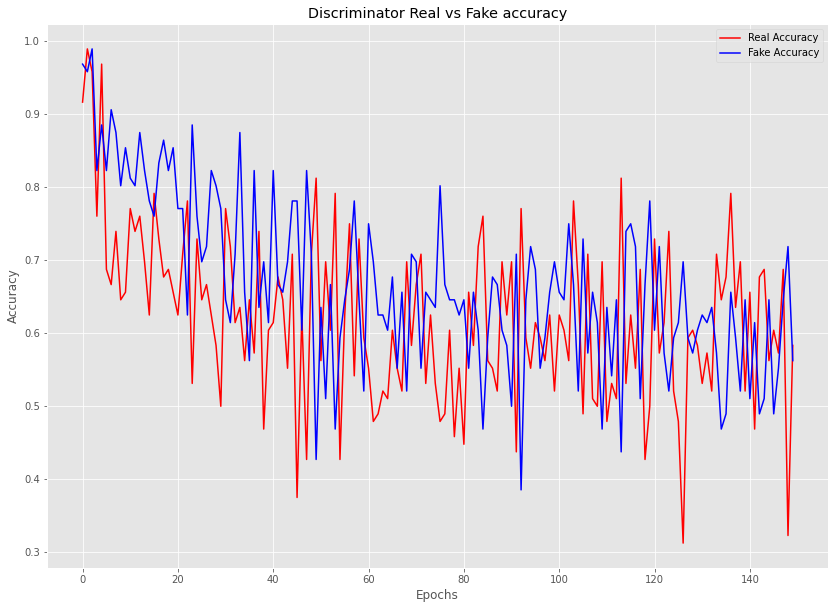

In [123]:
# mse with sigmoid
fig = plt.figure(figsize=(14, 10))
plt.plot(np.arange(epochs), all_real_acc, c='red', label = 'Real Accuracy')
plt.plot(np.arange(epochs), all_fake_acc, c='blue', label = 'Fake Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator Real vs Fake accuracy')
plt.show()

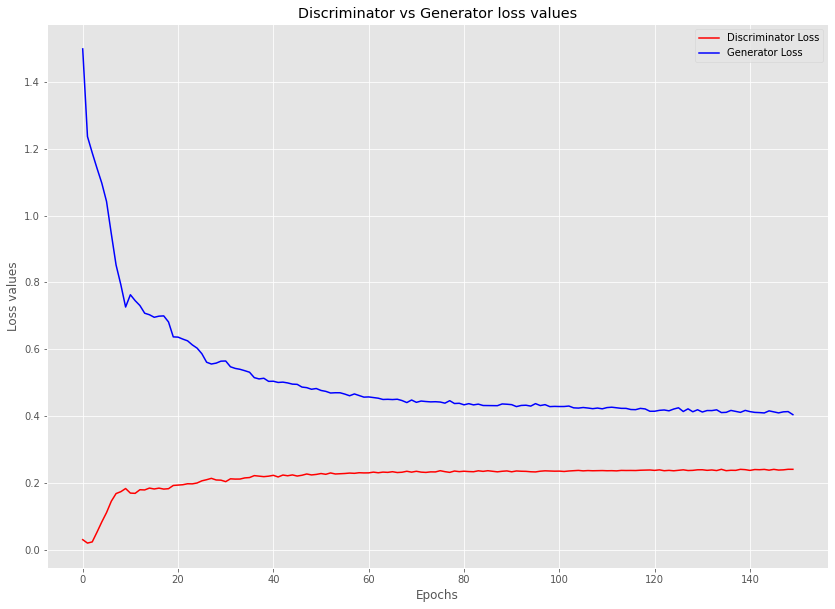

In [124]:
# mse with sigmoid
all_disc_loss_np = []
for i in all_disc_loss:
    all_disc_loss_np.append(i.item())

all_gen_loss_np = []
for i in all_gen_loss:
    all_gen_loss_np.append(i.item())

# Plot real and fake accuracy curve
fig = plt.figure(figsize=(14, 10))
plt.plot(np.arange(epochs), all_disc_loss_np, c='red', label = 'Discriminator Loss')
plt.plot(np.arange(epochs), all_gen_loss_np, c='blue', label = 'Generator Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Discriminator vs Generator loss values')
plt.show()

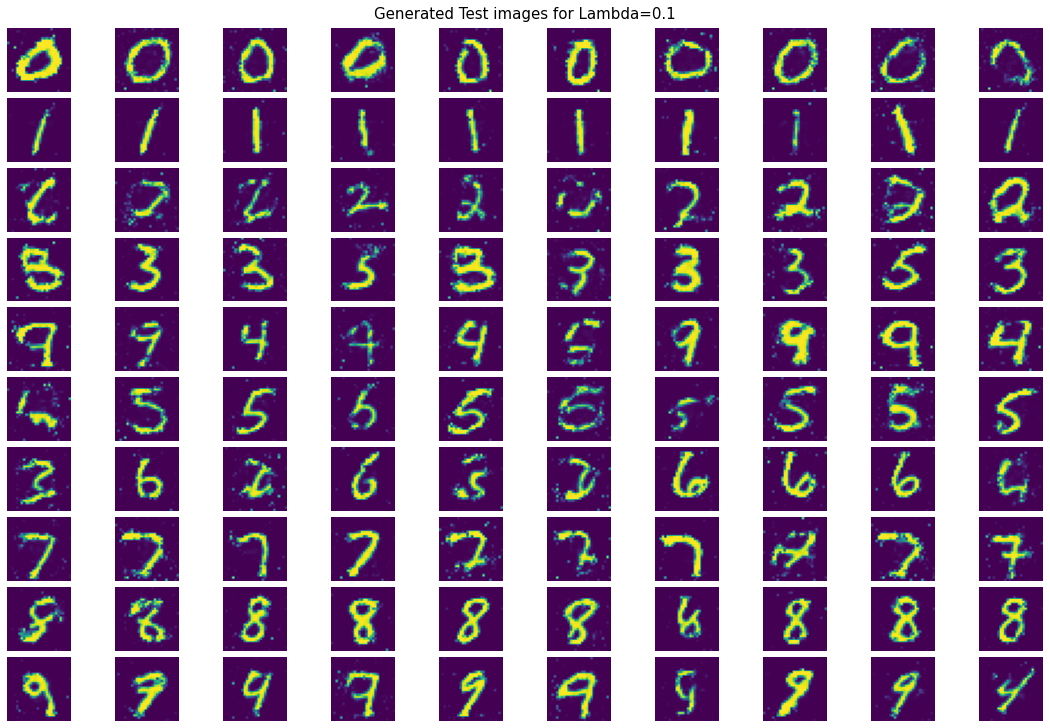

In [122]:
fig, ax = plt.subplots(10, 10, figsize = (15,10), constrained_layout=True)
fig.suptitle('Generated Test images for Lambda=0.1', fontsize=15)
for i in range(10):
    # generate fake images
    ix = np.where(y_test == i)
    patch_vector = x_test_center[ix][:10]
    patch_vector = patch_vector.reshape(patch_vector.shape[0], 100).to(device)
    noise =  torch.randn(10, 100).float().to(device) # 100 dim batch_size noise vector
    fake_image = generator((noise, patch_vector))
    for j in range(10):        
        ax[i,j].imshow(fake_image[j].detach().cpu().numpy().reshape(28, 28))
        ax[i,j].axis('off')


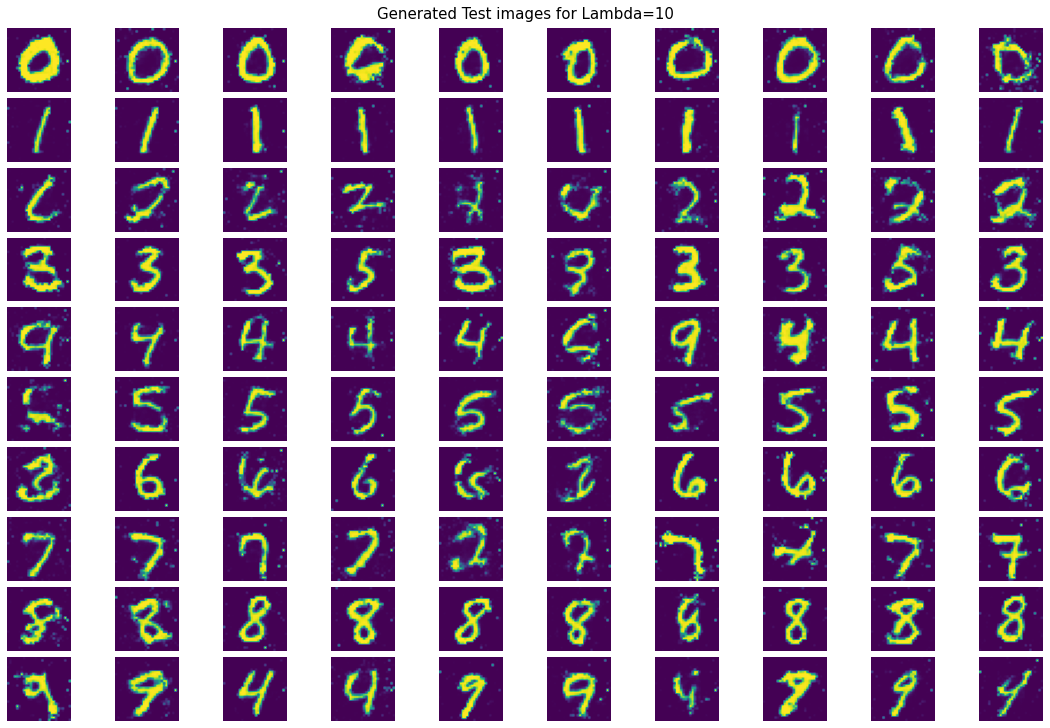

In [138]:
fig, ax = plt.subplots(10, 10, figsize = (15,10), constrained_layout=True)
fig.suptitle('Generated Test images for Lambda=10', fontsize=15)
for i in range(10):
    # generate fake images
    ix = np.where(y_test == i)
    patch_vector = x_test_center[ix][:10]
    patch_vector = patch_vector.reshape(patch_vector.shape[0], 100).to(device)
    noise =  torch.randn(10, 100).float().to(device) # 100 dim batch_size noise vector
    fake_image = generator((noise, patch_vector))
    for j in range(10):        
        ax[i,j].imshow(fake_image[j].detach().cpu().numpy().reshape(28, 28))
        ax[i,j].axis('off')
